# Trabajo Práctico: Predicción de precios de casas

## Carga de librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from math import sqrt
import time

from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
)
from sklearn.linear_model import (
    Ridge, RidgeCV, LinearRegression, SGDRegressor,
    ElasticNet, Lasso, LogisticRegression, ElasticNetCV, LassoCV)

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    auc, balanced_accuracy_score, log_loss
)

from sklearn.model_selection import (
    cross_val_score, StratifiedKFold, KFold, LeaveOneOut,
    GridSearchCV, RandomizedSearchCV, train_test_split
)



## Carga del dataset

In [89]:
# Cargar el dataset
df = pd.read_csv(r'weatherAUS.csv')

### Elegimos las ciudades

In [90]:
# Obtener los valores únicos de la columna 'Location'
unique_locations = df['Location'].unique()

In [91]:
# Seleccionar aleatoriamente 10 ciudades
selected_cities = np.random.choice(unique_locations, size=10, replace=False)


In [92]:
# Filtrar el DataFrame para quedarse solo con las ciudades seleccionadas
df = df[df['Location'].isin(selected_cities)]

# Mostrar las primeras filas del DataFrame filtrado
df.head()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [93]:
#Eliminaremos esta columna, ya que vamos a tomar las ubicaciones como si fueran una misma y así simplificar el modelo.
df.drop('Location', axis=1, inplace=True)

In [94]:
nulos_raintomorrow = df["RainTomorrow"].isnull().sum()

print("El Dataset cuenta con " +  str(nulos_raintomorrow) + "Valores nulos en la variable a predecir.")


El Dataset cuenta con 154Valores nulos en la variable a predecir.


# División del conjunto de datos, Train y Test

Dividimos el dataset en train y test antes de imputar nulos para evitar el data leakage. Al hacerlo por fecha, mantenemos la integridad temporal y respetamos el orden cronológico de los eventos. Esto es crucial para series temporales y problemas donde el tiempo importa. Si usáramos una división aleatoria como `train_test_split`, podríamos filtrar datos de prueba en el entrenamiento, lo que llevaría a un modelo sobreajustado que no generaliza bien en datos futuros.

In [95]:
# Convierto la columna 'Date' a tipo datetime
df["Date"] = pd.to_datetime(df["Date"])

# Mostrar la primera y última fecha
primera_fecha = df['Date'].min()
ultima_fecha = df['Date'].max()

print("Primera fecha:", primera_fecha)
print("Última fecha:", ultima_fecha)

# Calcular la fecha que abarque el 80% de los datos
fecha_80porciento = df['Date'].quantile(0.8)

print("Fecha que abarca el 80% de los datos:", fecha_80porciento)

Primera fecha: 2007-11-01 00:00:00
Última fecha: 2017-06-25 00:00:00
Fecha que abarca el 80% de los datos: 2015-10-15 00:00:00


In [96]:
# Dividir los datos en conjuntos de entrenamiento y prueba basados en la fecha
train = df[df['Date'] <= fecha_80porciento]

test = df[df['Date'] > fecha_80porciento]

Ya que la fecha no aporta nada más de valor, procedemos a eliminarla para reducir un poco más la dimensionalidad y así la complejidad de nuestro modelo.

In [97]:
train = train.drop('Date', axis=1)

test = test.drop('Date', axis=1)

In [98]:
train

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141680,23.3,32.8,0.0,8.4,10.5,N,35.0,ESE,NNW,13.0,...,62.0,53.0,1017.2,1012.4,3.0,3.0,29.0,30.8,No,No
141681,24.3,32.3,0.0,8.0,9.1,N,35.0,N,NNW,11.0,...,65.0,47.0,1017.4,1012.5,2.0,2.0,28.8,31.4,No,No
141682,23.8,32.9,0.0,5.6,10.9,NW,33.0,NE,NNW,2.0,...,62.0,45.0,1015.8,1011.9,1.0,1.0,29.1,31.5,No,No
141683,23.3,33.2,0.0,7.6,10.7,NNW,33.0,NNE,NW,4.0,...,60.0,41.0,1015.9,1011.5,2.0,1.0,28.6,32.2,No,No


In [99]:
test

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
2421,13.1,29.6,0.0,NaN,NaN,SSE,22.0,SSE,S,2.0,...,79.0,52.0,1021.2,1019.2,8.0,7.0,18.2,25.8,No,No
2422,16.0,29.0,0.0,NaN,NaN,WSW,33.0,SE,W,6.0,...,82.0,46.0,1023.0,1022.8,8.0,8.0,19.1,25.3,No,No
2423,8.6,27.5,0.0,NaN,NaN,NW,22.0,S,SE,6.0,...,64.0,40.0,1026.9,1024.1,NaN,NaN,15.8,26.2,No,No
2424,8.3,29.2,0.0,NaN,NaN,SSE,22.0,SSE,SSE,4.0,...,63.0,44.0,1024.5,1019.9,NaN,NaN,16.0,27.9,No,No
2425,11.3,31.8,0.0,NaN,NaN,NW,54.0,E,NNW,2.0,...,64.0,31.0,1019.4,1013.7,NaN,8.0,18.7,30.3,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142299,21.2,32.6,0.0,7.6,8.6,E,37.0,SE,SE,13.0,...,56.0,28.0,1014.6,1011.2,7.0,0.0,24.8,32.0,No,No
142300,20.7,32.8,0.0,5.6,11.0,E,33.0,E,W,17.0,...,46.0,23.0,1015.3,1011.8,0.0,0.0,24.8,32.1,No,No
142301,19.5,31.8,0.0,6.2,10.6,ESE,26.0,SE,NNW,9.0,...,62.0,58.0,1014.9,1010.7,1.0,1.0,24.8,29.2,No,No
142302,20.2,31.7,0.0,5.6,10.7,ENE,30.0,ENE,NNW,15.0,...,73.0,32.0,1013.9,1009.7,6.0,5.0,25.4,31.0,No,No


# Visualización de datos Train

Examinaremos los datos para un primer vistazo.

In [100]:
train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [101]:
train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

A continuación, examinaremos qué tipos de variables son estas columnas.

In [102]:
train.dtypes

,0
MinTemp,float64
MaxTemp,float64
Rainfall,float64
Evaporation,float64
Sunshine,float64
WindGustDir,object
WindGustSpeed,float64
WindDir9am,object
WindDir3pm,object
WindSpeed9am,float64


Investiguemos la presencia de valores nulos en los datos.

In [103]:
train.isna().sum()

,0
MinTemp,37
MaxTemp,26
Rainfall,106
Evaporation,8603
Sunshine,11006
WindGustDir,602
WindGustSpeed,597
WindDir9am,2091
WindDir3pm,397
WindSpeed9am,287


Los valores faltantes de cada columna los trataremos.

Para concluir nuestra primera inspección, veremos las estadísticas descriptivas del conjunto de datos.

In [104]:
train.describe(include='all')

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,24750.000000,24761.000000,24681.000000,16184.000000,13781.000000,24185,24190.000000,22696,24390,24500.000000,...,24608.000000,24686.000000,23953.000000,23961.000000,17456.000000,17213.000000,24681.000000,24728.000000,24681,24681
unique,NaN,NaN,NaN,NaN,NaN,16,NaN,16,16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,NaN,NaN,NaN,NaN,NaN,NW,NaN,E,NNW,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No
freq,NaN,NaN,NaN,NaN,NaN,2258,NaN,2171,2564,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19708,19709
mean,11.380582,23.469605,2.071569,5.943259,8.198121,NaN,38.611658,NaN,NaN,12.875388,...,67.811687,46.762618,1017.486678,1014.963332,4.102887,4.164759,16.321373,22.068214,NaN,NaN
std,7.161850,7.622256,7.554071,4.825836,3.570834,NaN,12.994540,NaN,NaN,8.460806,...,19.718379,20.553142,7.345621,7.174622,2.981805,2.833053,7.091680,7.453837,NaN,NaN
min,-8.200000,2.600000,0.000000,0.000000,0.000000,NaN,6.000000,NaN,NaN,0.000000,...,0.000000,0.000000,985.000000,980.200000,0.000000,0.000000,-3.100000,2.300000,NaN,NaN
25%,6.200000,17.200000,0.000000,2.800000,5.800000,NaN,30.000000,NaN,NaN,7.000000,...,55.000000,32.000000,1012.400000,1009.800000,1.000000,1.000000,11.200000,16.000000,NaN,NaN
50%,11.000000,22.600000,0.000000,5.000000,9.100000,NaN,37.000000,NaN,NaN,11.000000,...,70.000000,46.000000,1017.200000,1014.600000,4.000000,4.000000,15.600000,21.200000,NaN,NaN
75%,16.200000,30.000000,0.400000,8.000000,10.900000,NaN,46.000000,NaN,NaN,19.000000,...,83.000000,60.000000,1022.600000,1020.000000,7.000000,7.000000,21.300000,28.200000,NaN,NaN


In [105]:
# Información general del dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24787 entries, 0 to 141684
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        24750 non-null  float64
 1   MaxTemp        24761 non-null  float64
 2   Rainfall       24681 non-null  float64
 3   Evaporation    16184 non-null  float64
 4   Sunshine       13781 non-null  float64
 5   WindGustDir    24185 non-null  object 
 6   WindGustSpeed  24190 non-null  float64
 7   WindDir9am     22696 non-null  object 
 8   WindDir3pm     24390 non-null  object 
 9   WindSpeed9am   24500 non-null  float64
 10  WindSpeed3pm   24504 non-null  float64
 11  Humidity9am    24608 non-null  float64
 12  Humidity3pm    24686 non-null  float64
 13  Pressure9am    23953 non-null  float64
 14  Pressure3pm    23961 non-null  float64
 15  Cloud9am       17456 non-null  float64
 16  Cloud3pm       17213 non-null  float64
 17  Temp9am        24681 non-null  float64
 18  Temp3pm   

In [106]:
# Contamos el número total de filas que tengan todos sus valores como nulos
nulas = train.isnull().all(axis=1).sum()
nulas

3

In [107]:
train.count()

,0
MinTemp,24750
MaxTemp,24761
Rainfall,24681
Evaporation,16184
Sunshine,13781
WindGustDir,24185
WindGustSpeed,24190
WindDir9am,22696
WindDir3pm,24390
WindSpeed9am,24500


# Graficos de Train

### MinTemp

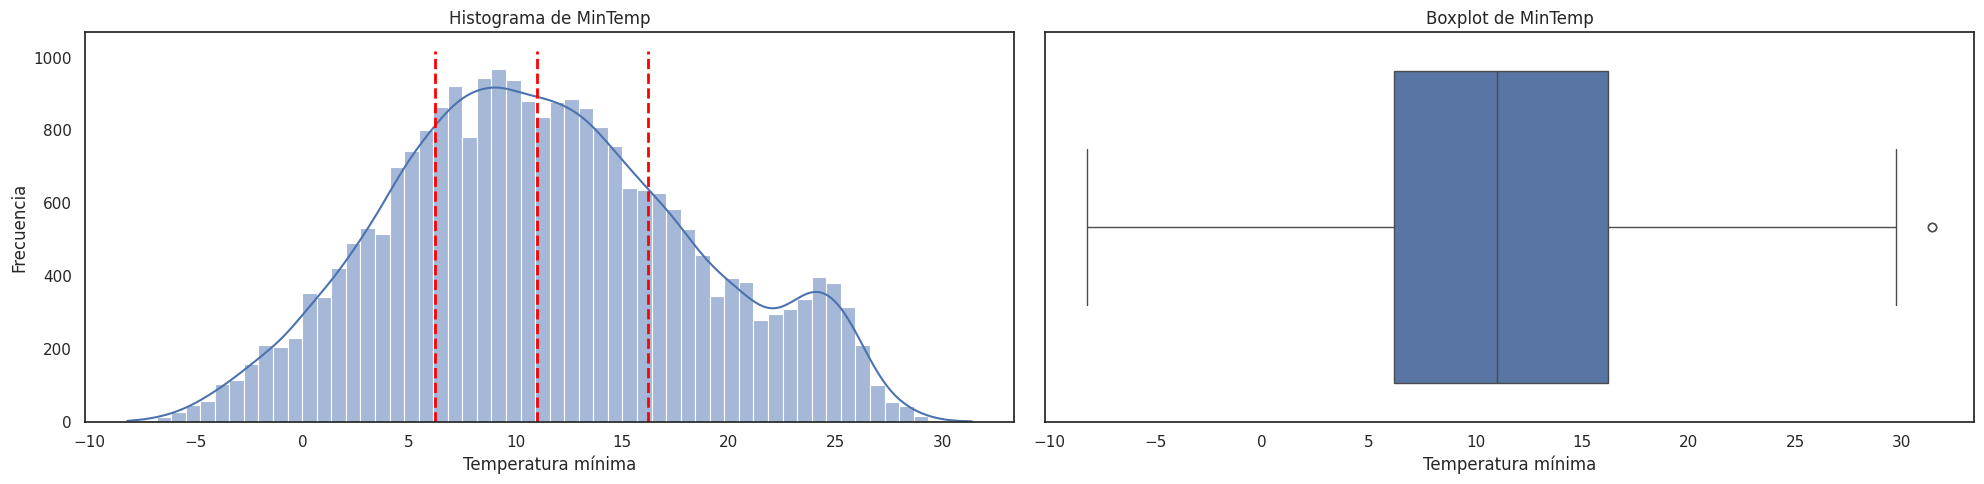

,MinTemp
count,24750.000000
mean,11.380582
std,7.161850
min,-8.200000
25%,6.200000
50%,11.000000
75%,16.200000
max,31.400000


In [108]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['MinTemp'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de MinTemp')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['MinTemp'].quantile(0.25)
q2 = train['MinTemp'].quantile(0.5)
q3 = train['MinTemp'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['MinTemp'], ax=axs[1])
axs[1].set_title('Boxplot de MinTemp')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()

train['MinTemp'].describe()

### MaxTemp

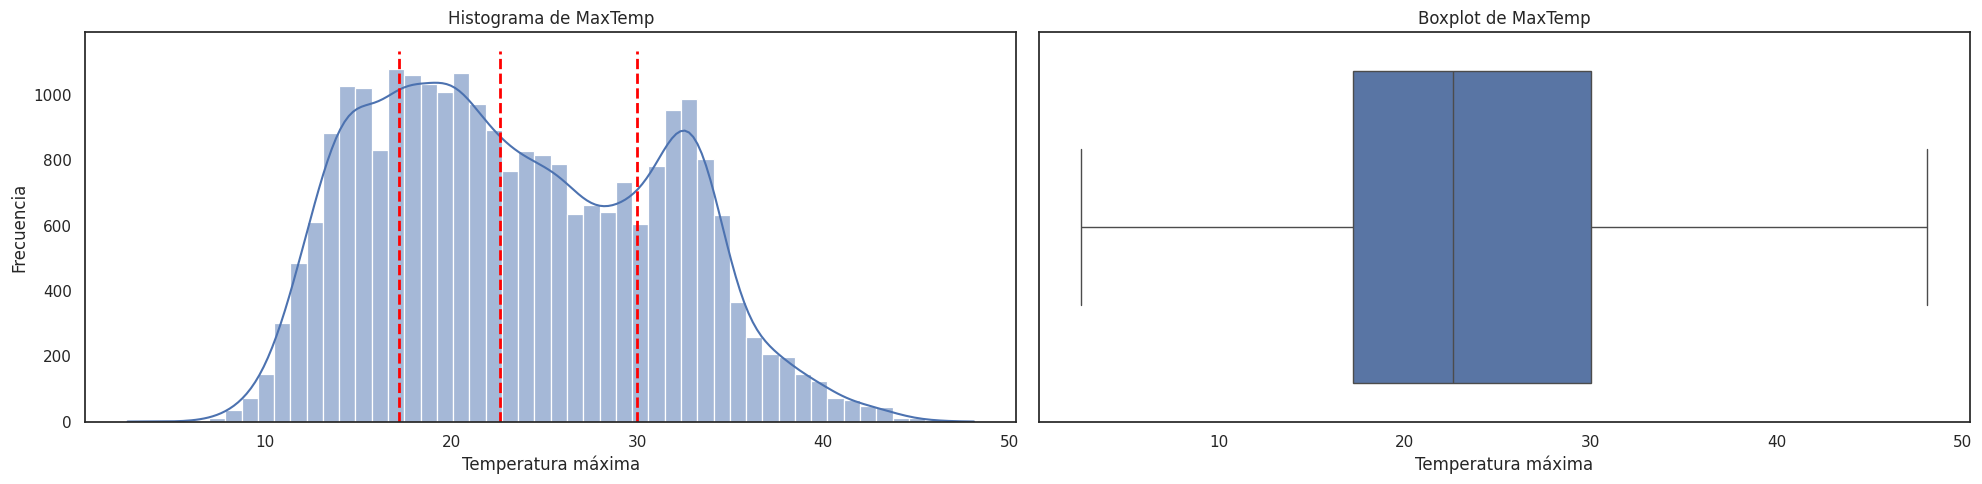

,MaxTemp
count,24761.000000
mean,23.469605
std,7.622256
min,2.600000
25%,17.200000
50%,22.600000
75%,30.000000
max,48.100000


In [109]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['MaxTemp'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de MaxTemp')
axs[0].set_xlabel('Temperatura máxima')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['MaxTemp'].quantile(0.25)
q2 = train['MaxTemp'].quantile(0.5)
q3 = train['MaxTemp'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['MaxTemp'], ax=axs[1])
axs[1].set_title('Boxplot de MaxTemp')
axs[1].set_xlabel('Temperatura máxima')

plt.tight_layout()
plt.show()

train['MaxTemp'].describe()


### Rainfall

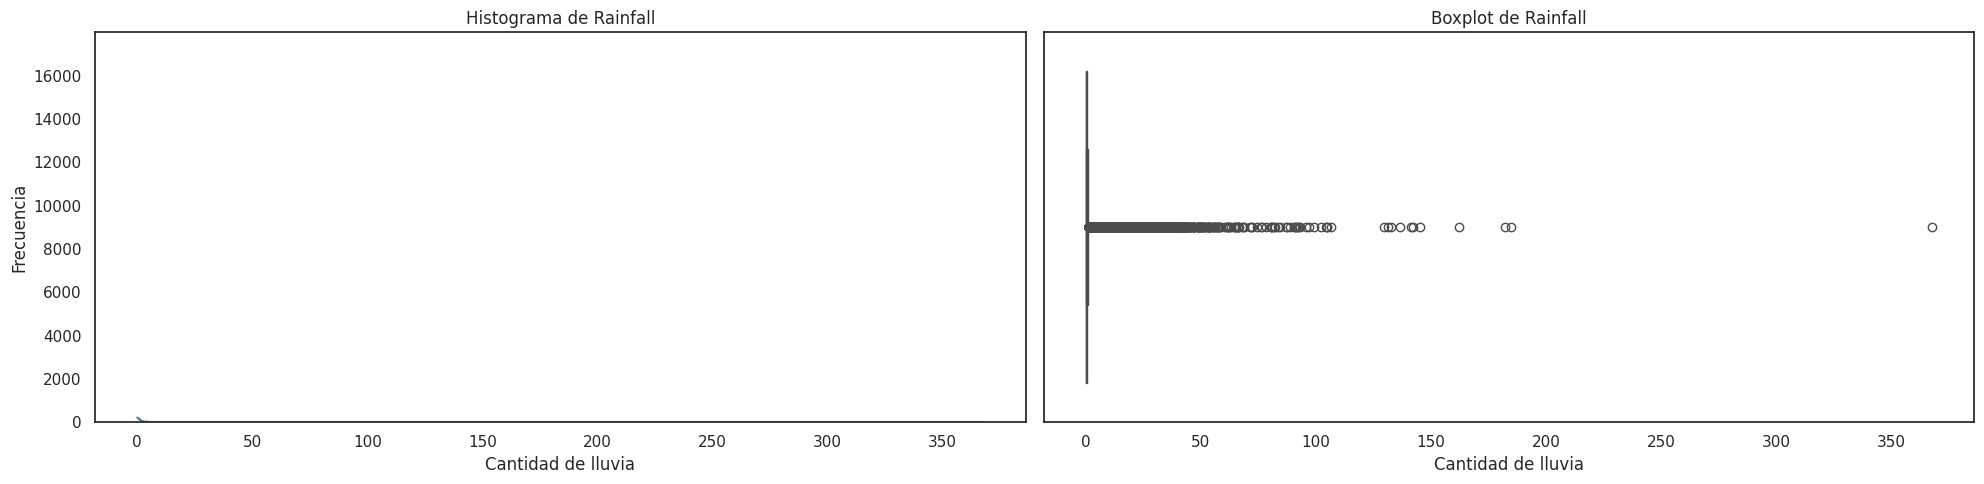

,Rainfall
count,24681.000000
mean,2.071569
std,7.554071
min,0.000000
25%,0.000000
50%,0.000000
75%,0.400000
max,367.600000


In [110]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Cantidad de lluvia')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=train['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Cantidad de lluvia')

plt.tight_layout()
plt.show()

train['Rainfall'].describe()


### Evaporation

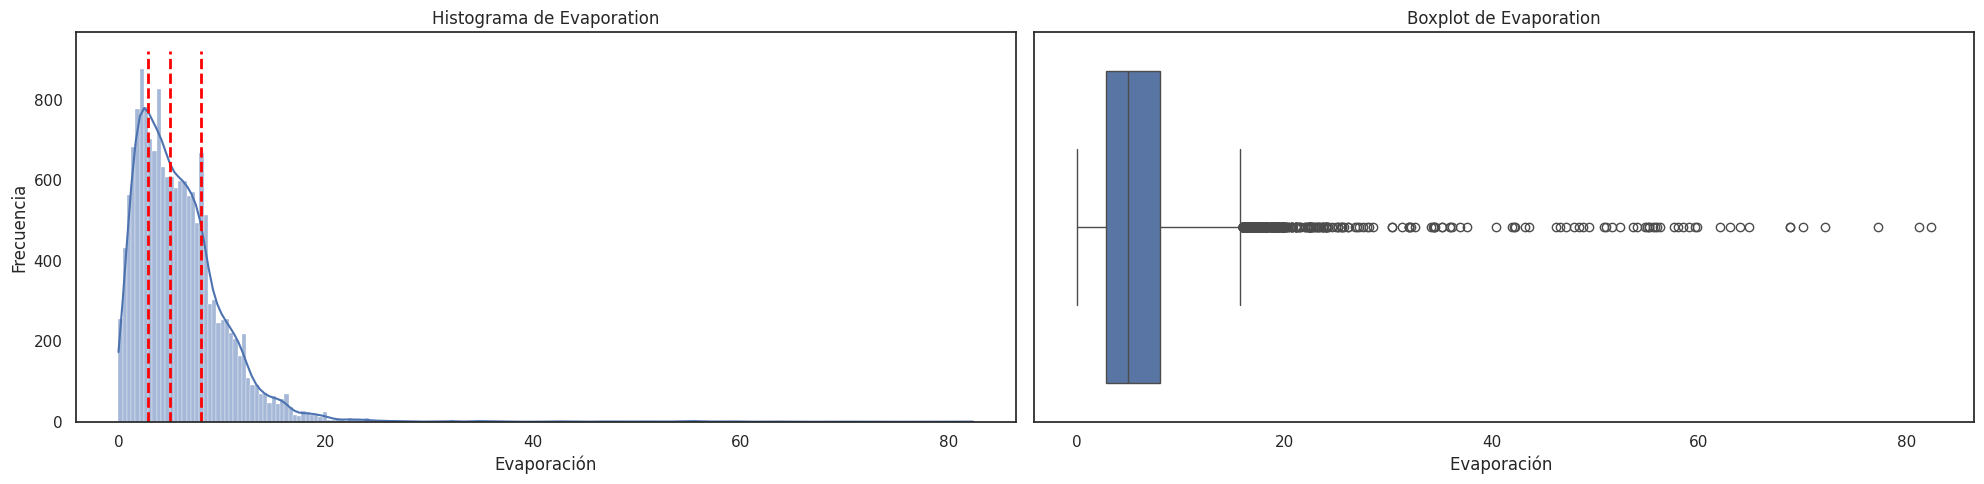

,Evaporation
count,16184.000000
mean,5.943259
std,4.825836
min,0.000000
25%,2.800000
50%,5.000000
75%,8.000000
max,82.400000


In [111]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Evaporation'], kde=True, ax=axs[0])

# Calcular cuartiles
q1 = train['Evaporation'].quantile(0.25)
q2 = train['Evaporation'].quantile(0.5)
q3 = train['Evaporation'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

axs[0].set_title('Histograma de Evaporation')
axs[0].set_xlabel('Evaporación')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=train['Evaporation'], ax=axs[1])
axs[1].set_title('Boxplot de Evaporation')
axs[1].set_xlabel('Evaporación ')

plt.tight_layout()
plt.show()

train['Evaporation'].describe()



### Sunshine

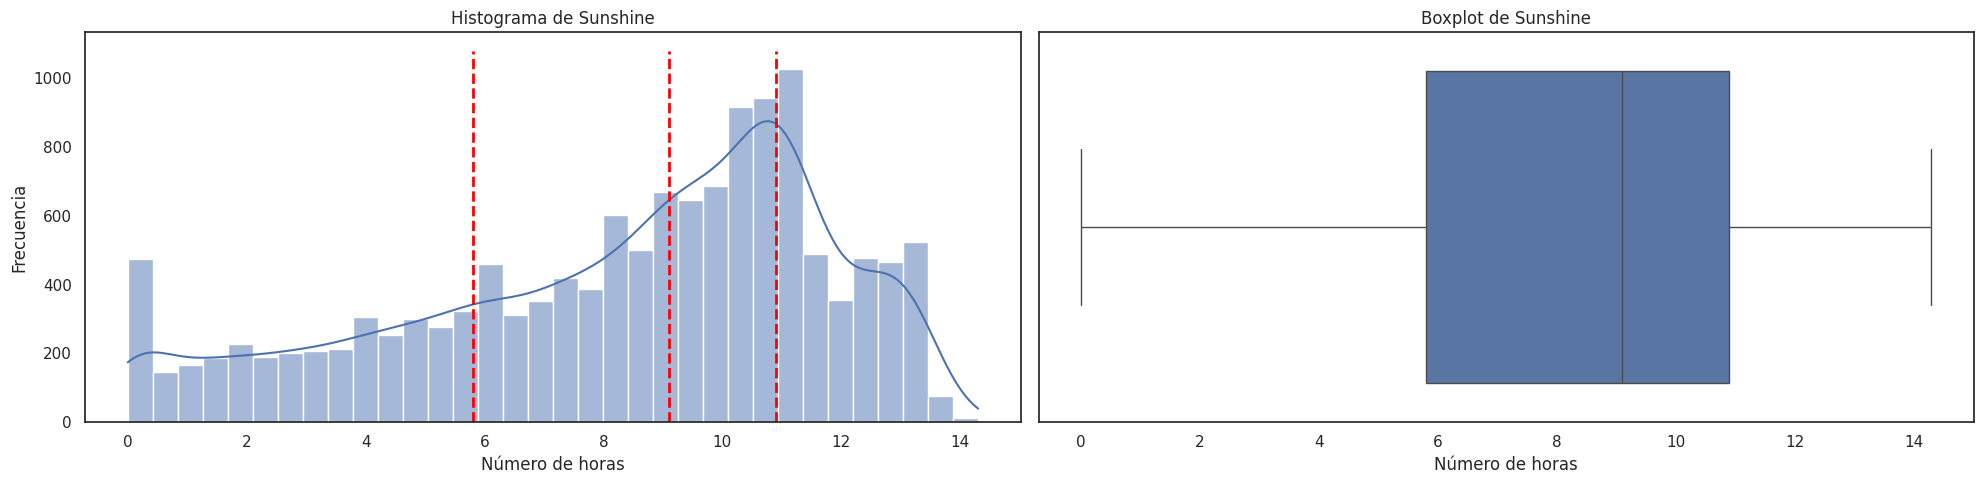

,Sunshine
count,13781.000000
mean,8.198121
std,3.570834
min,0.000000
25%,5.800000
50%,9.100000
75%,10.900000
max,14.300000


In [112]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Sunshine'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Sunshine')
axs[0].set_xlabel('Número de horas')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Sunshine'].quantile(0.25)
q2 = train['Sunshine'].quantile(0.5)
q3 = train['Sunshine'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Sunshine'], ax=axs[1])
axs[1].set_title('Boxplot de Sunshine')
axs[1].set_xlabel('Número de horas')

plt.tight_layout()
plt.show()

train['Sunshine'].describe()

### WindGustDir

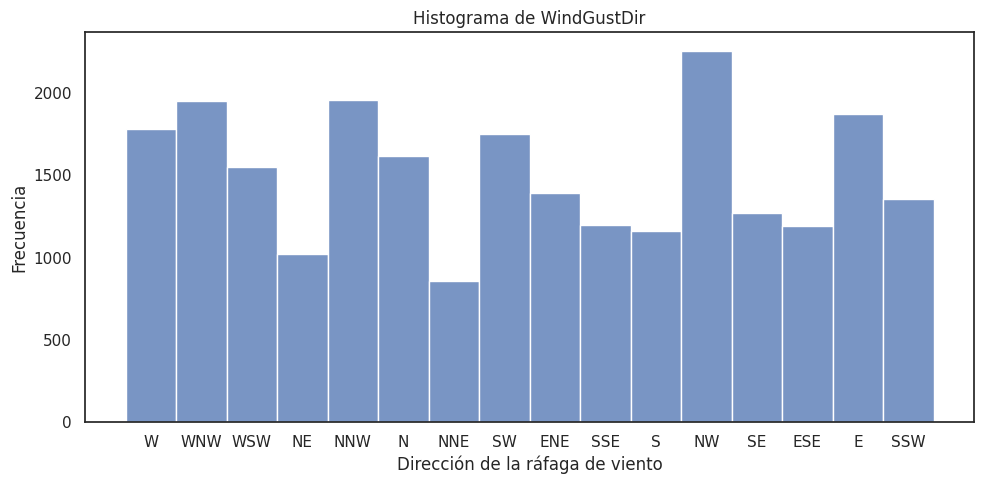

,WindGustDir
count,24185
unique,16
top,NW
freq,2258


In [113]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(train['WindGustDir'])
axs.set_title('Histograma de WindGustDir')
axs.set_xlabel('Dirección de la ráfaga de viento')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

train['WindGustDir'].describe()

### WindGustSpeed

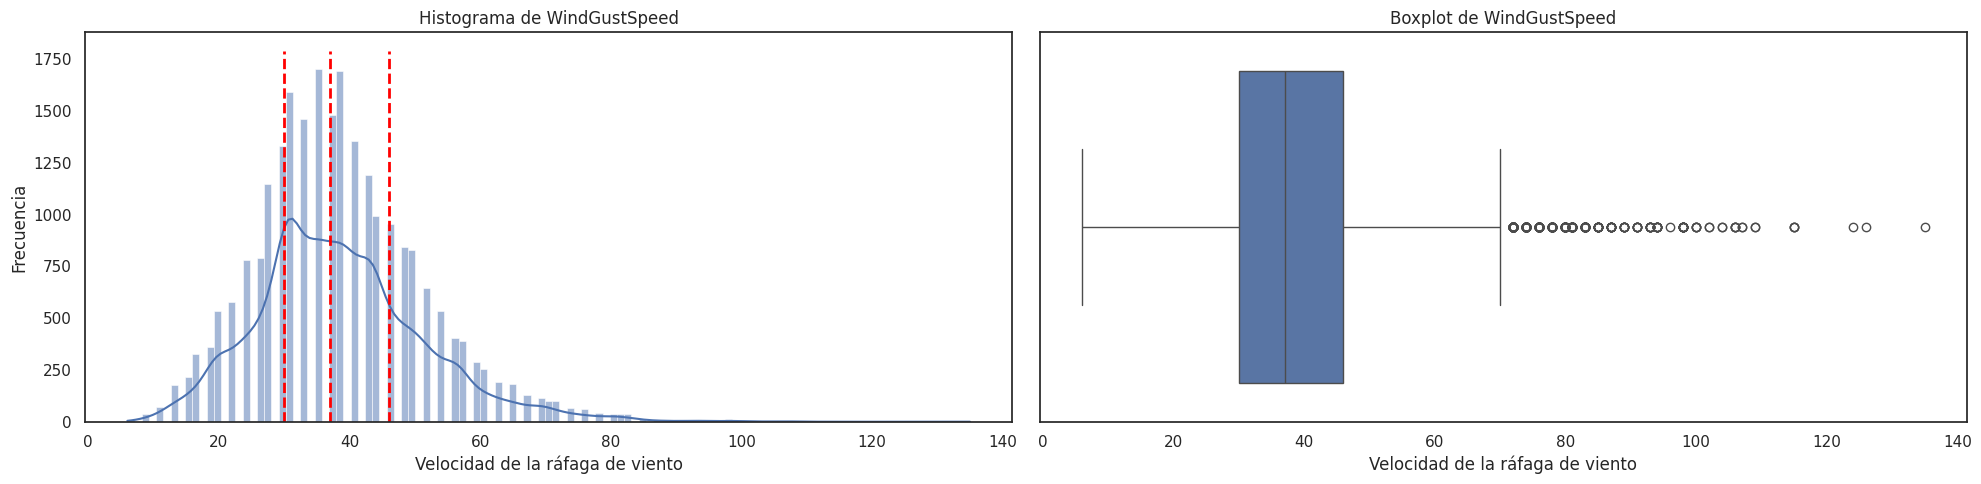

,WindGustSpeed
count,24190.000000
mean,38.611658
std,12.994540
min,6.000000
25%,30.000000
50%,37.000000
75%,46.000000
max,135.000000


In [114]:

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['WindGustSpeed'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindGustSpeed')
axs[0].set_xlabel('Velocidad de la ráfaga de viento')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['WindGustSpeed'].quantile(0.25)
q2 = train['WindGustSpeed'].quantile(0.5)
q3 = train['WindGustSpeed'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['WindGustSpeed'], ax=axs[1])
axs[1].set_title('Boxplot de WindGustSpeed')
axs[1].set_xlabel('Velocidad de la ráfaga de viento')

plt.tight_layout()
plt.show()
train['WindGustSpeed'].describe()

### WindDir9am

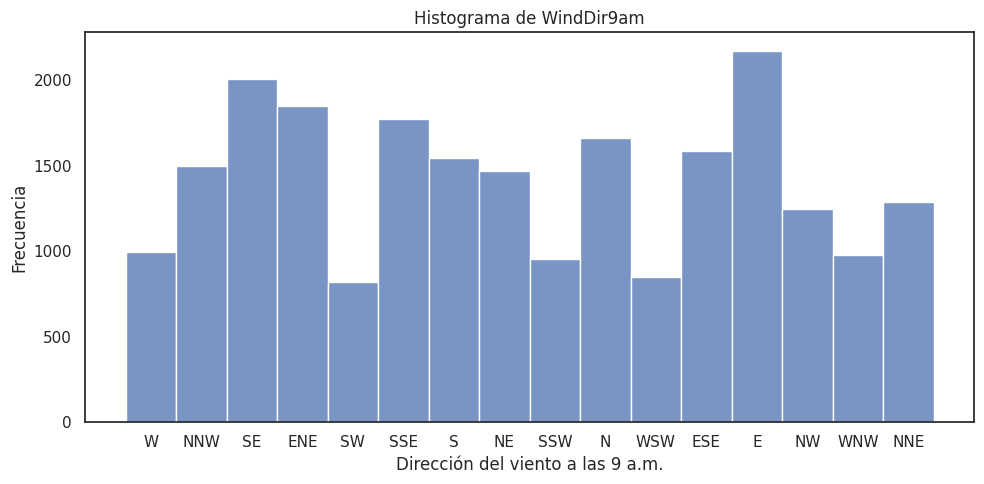

,WindDir9am
count,22696
unique,16
top,E
freq,2171


In [115]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(train['WindDir9am'])
axs.set_title('Histograma de WindDir9am')
axs.set_xlabel('Dirección del viento a las 9 a.m.')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

train['WindDir9am'].describe()

### WindDir3pm

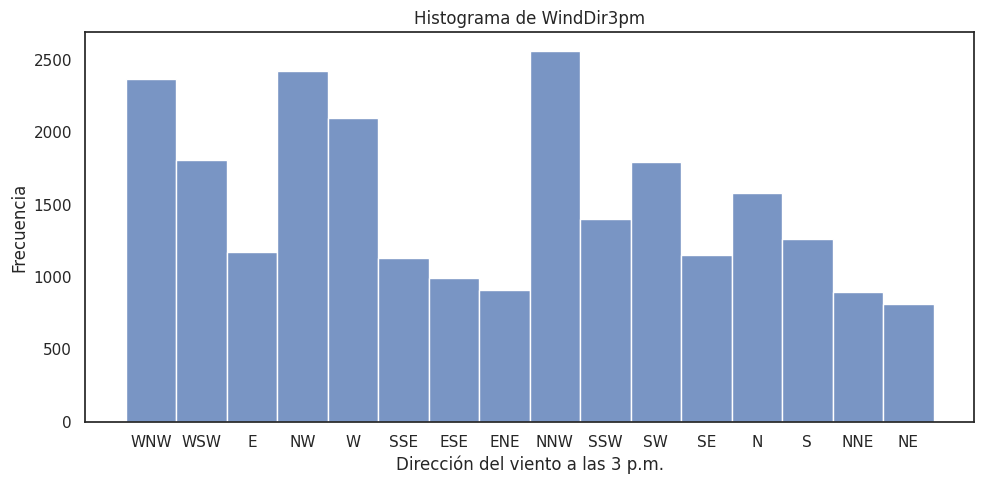

,WindDir3pm
count,24390
unique,16
top,NNW
freq,2564


In [116]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(train['WindDir3pm'])
axs.set_title('Histograma de WindDir3pm')
axs.set_xlabel('Dirección del viento a las 3 p.m.')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

train['WindDir3pm'].describe()

### WindSpeed9am

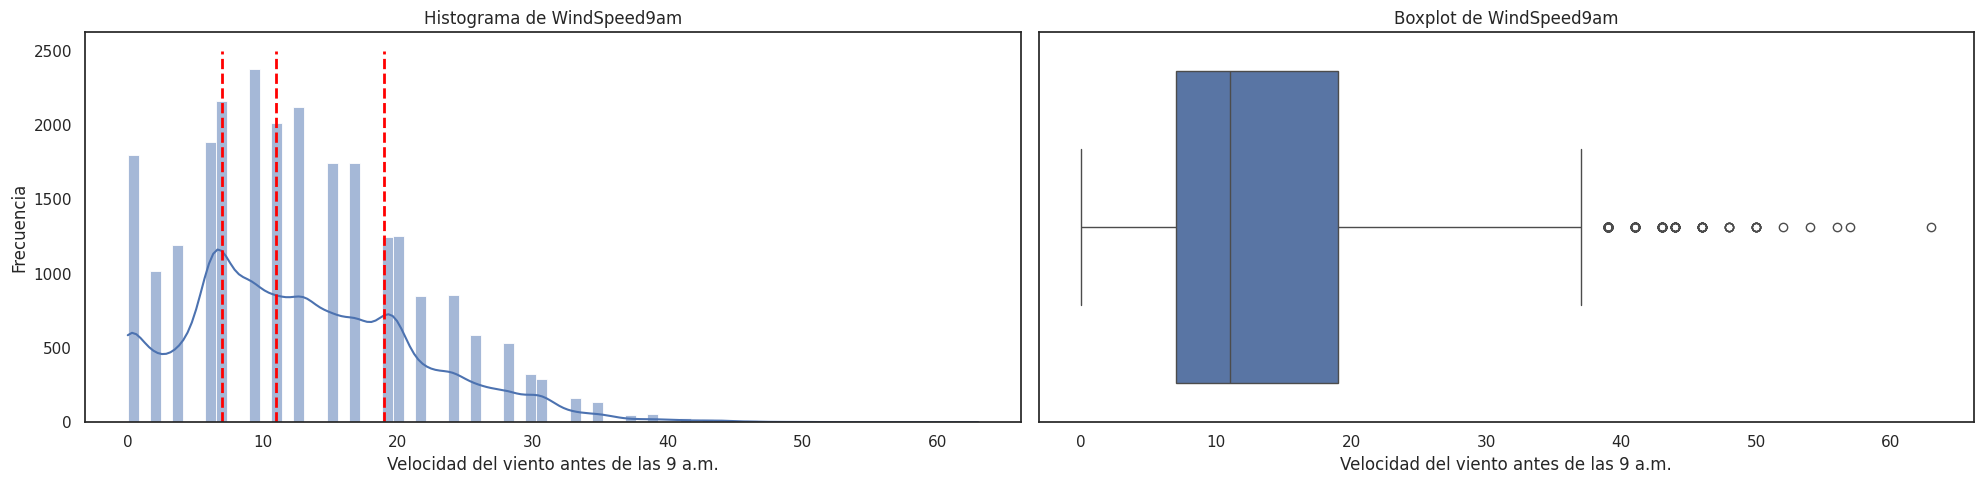

In [117]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['WindSpeed9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindSpeed9am')
axs[0].set_xlabel('Velocidad del viento antes de las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['WindSpeed9am'].quantile(0.25)
q2 = train['WindSpeed9am'].quantile(0.5)
q3 = train['WindSpeed9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['WindSpeed9am'], ax=axs[1])
axs[1].set_title('Boxplot de WindSpeed9am')
axs[1].set_xlabel('Velocidad del viento antes de las 9 a.m.')

plt.tight_layout()
plt.show()


### WindSpeed3pm

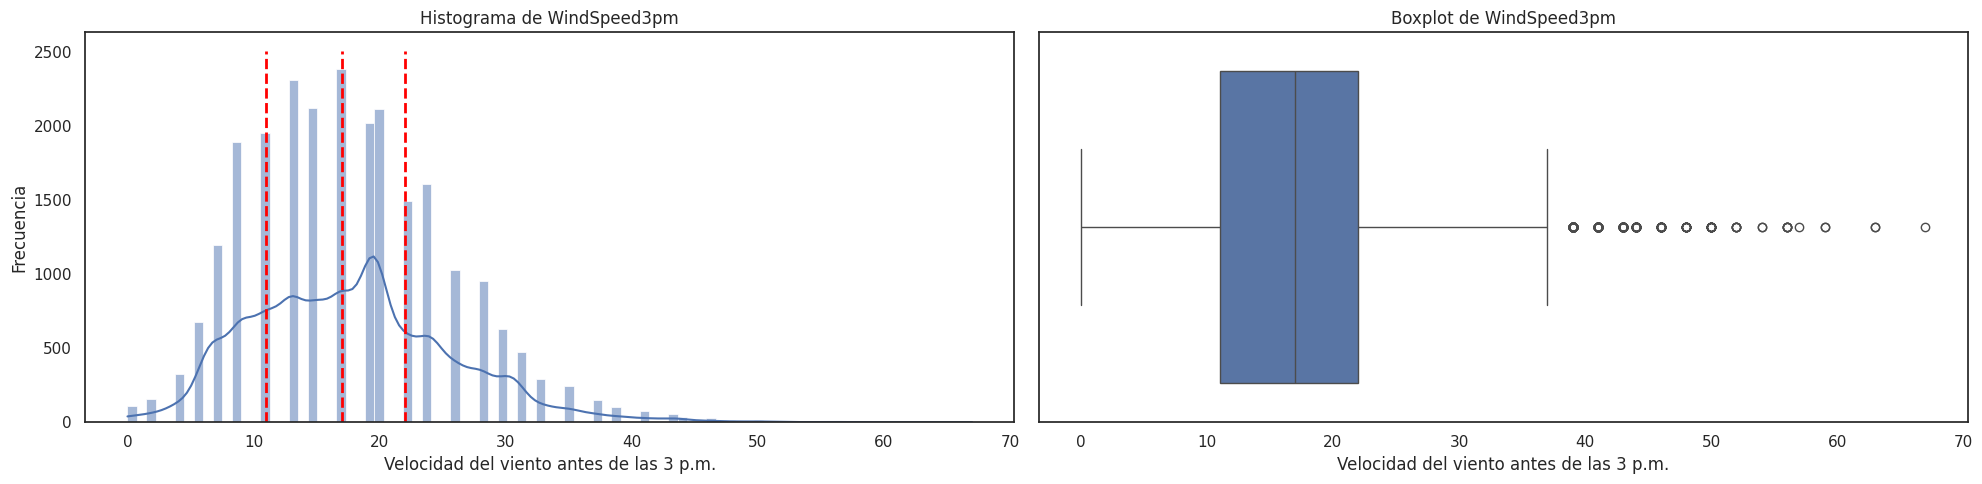

,WindSpeed3pm
count,24504.000000
mean,17.673074
std,7.941888
min,0.000000
25%,11.000000
50%,17.000000
75%,22.000000
max,67.000000


In [118]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['WindSpeed3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindSpeed3pm')
axs[0].set_xlabel('Velocidad del viento antes de las 3 p.m.')
axs[0].set_ylabel('Frecuencia')


# Calcular cuartiles
q1 = train['WindSpeed3pm'].quantile(0.25)
q2 = train['WindSpeed3pm'].quantile(0.5)
q3 = train['WindSpeed3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['WindSpeed3pm'], ax=axs[1])
axs[1].set_title('Boxplot de WindSpeed3pm')
axs[1].set_xlabel('Velocidad del viento antes de las 3 p.m.')

plt.tight_layout()
plt.show()

train['WindSpeed3pm'].describe()

### Humidity9am

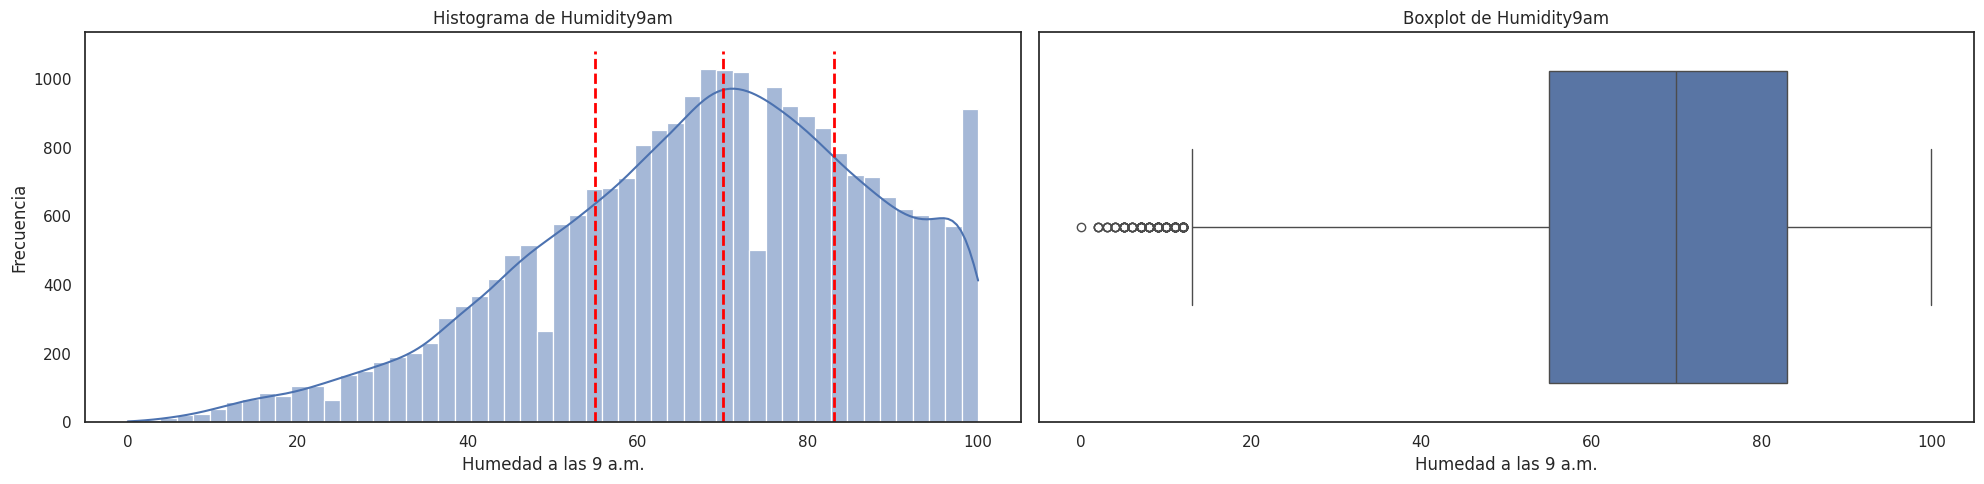

In [119]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Humidity9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Humidity9am')
axs[0].set_xlabel('Humedad a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')


# Calcular cuartiles
q1 = train['Humidity9am'].quantile(0.25)
q2 = train['Humidity9am'].quantile(0.5)
q3 = train['Humidity9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Humidity9am'], ax=axs[1])
axs[1].set_title('Boxplot de Humidity9am')
axs[1].set_xlabel('Humedad a las 9 a.m.')

plt.tight_layout()
plt.show()



### Humidity3pm

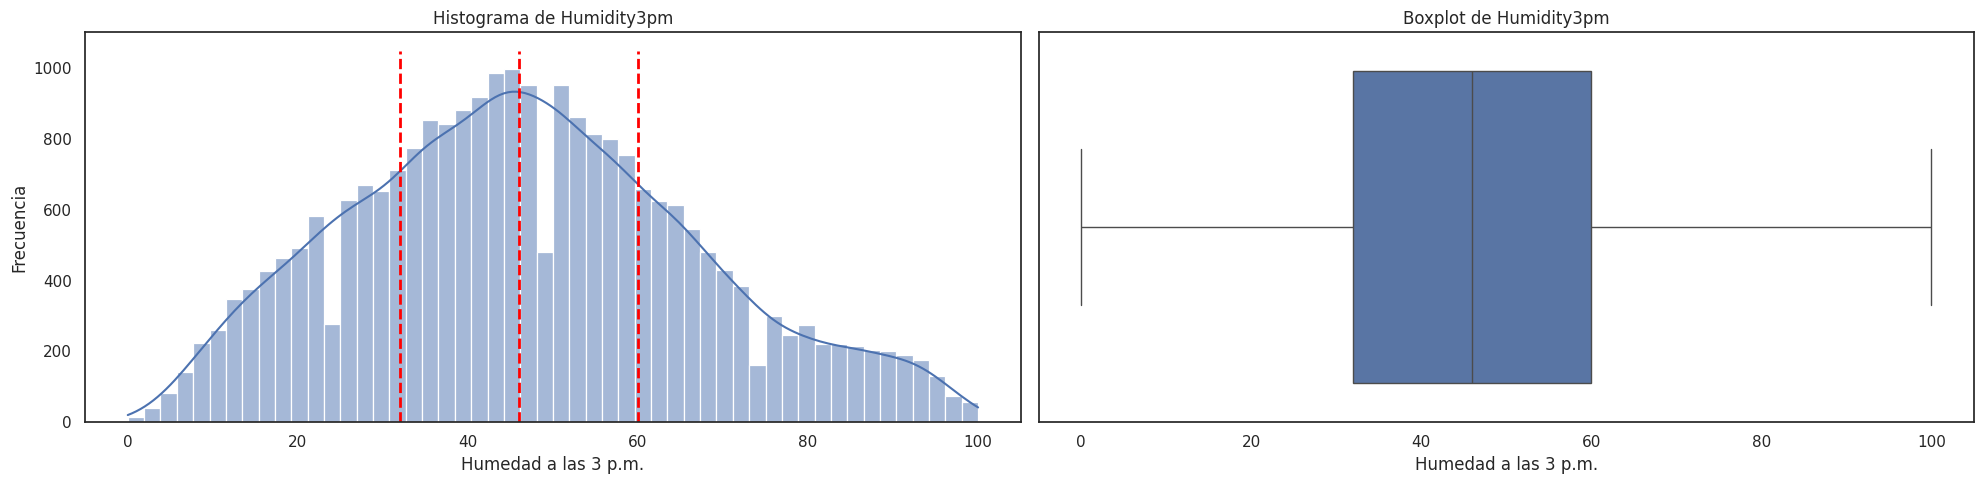

In [120]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Humidity3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Humidity3pm')
axs[0].set_xlabel('Humedad a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')


# Calcular cuartiles
q1 = train['Humidity3pm'].quantile(0.25)
q2 = train['Humidity3pm'].quantile(0.5)
q3 = train['Humidity3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Humidity3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Humidity3pm')
axs[1].set_xlabel('Humedad a las 3 p.m.')

plt.tight_layout()
plt.show()


### Pressure9am

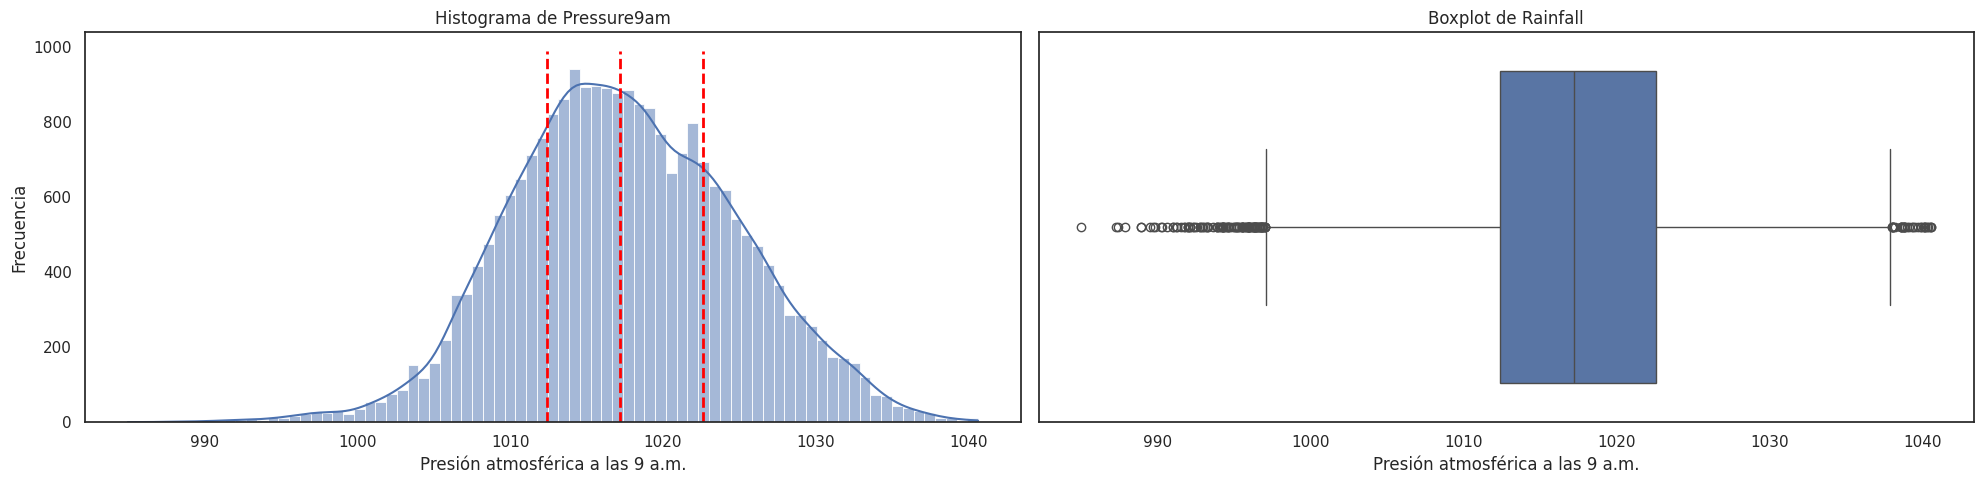

In [121]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Pressure9am'], kde=True, ax=axs[0])

axs[0].set_title('Histograma de Pressure9am')
axs[0].set_xlabel('Presión atmosférica a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')


# Calcular cuartiles
q1 = train['Pressure9am'].quantile(0.25)
q2 = train['Pressure9am'].quantile(0.5)
q3 = train['Pressure9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Pressure9am'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Presión atmosférica a las 9 a.m.')

plt.tight_layout()
plt.show()



### Pressure3pm

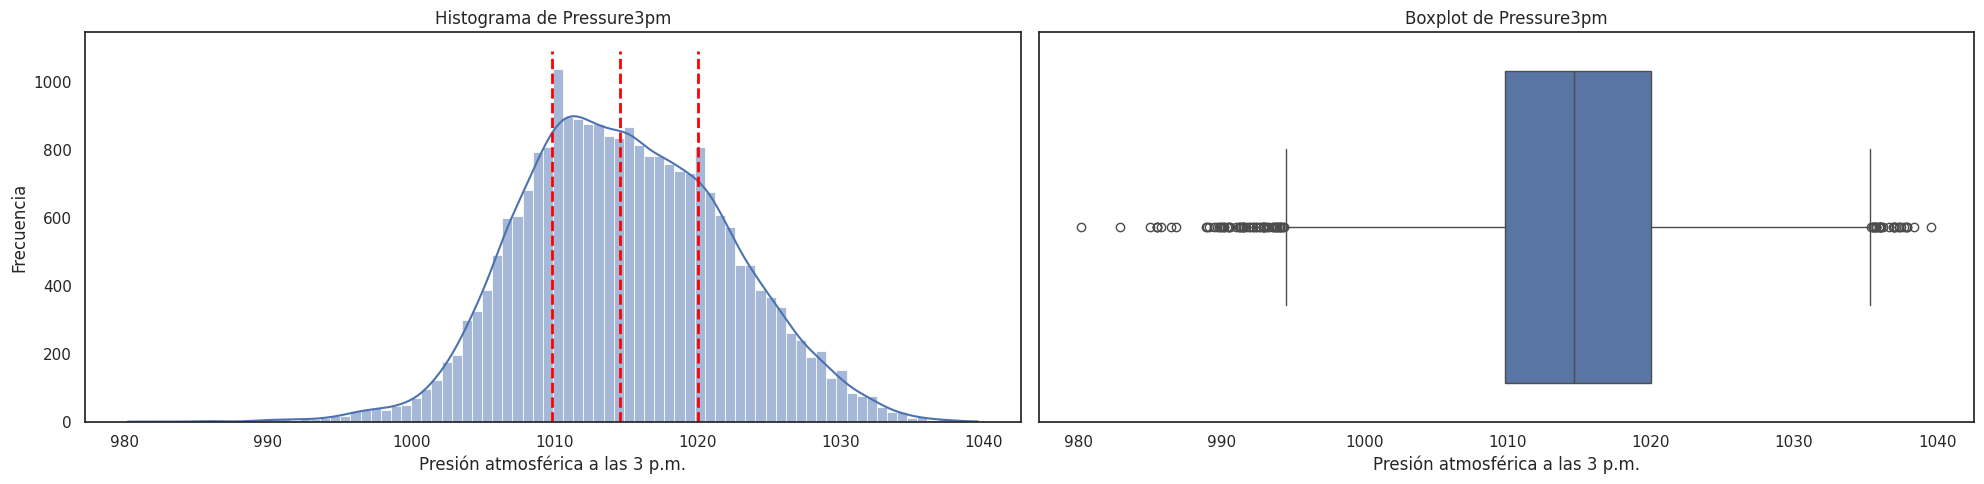

In [122]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Pressure3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Pressure3pm')
axs[0].set_xlabel('Presión atmosférica a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Pressure3pm'].quantile(0.25)
q2 = train['Pressure3pm'].quantile(0.5)
q3 = train['Pressure3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Pressure3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Pressure3pm')
axs[1].set_xlabel('Presión atmosférica a las 3 p.m.')

plt.tight_layout()
plt.show()



### Cloud9am

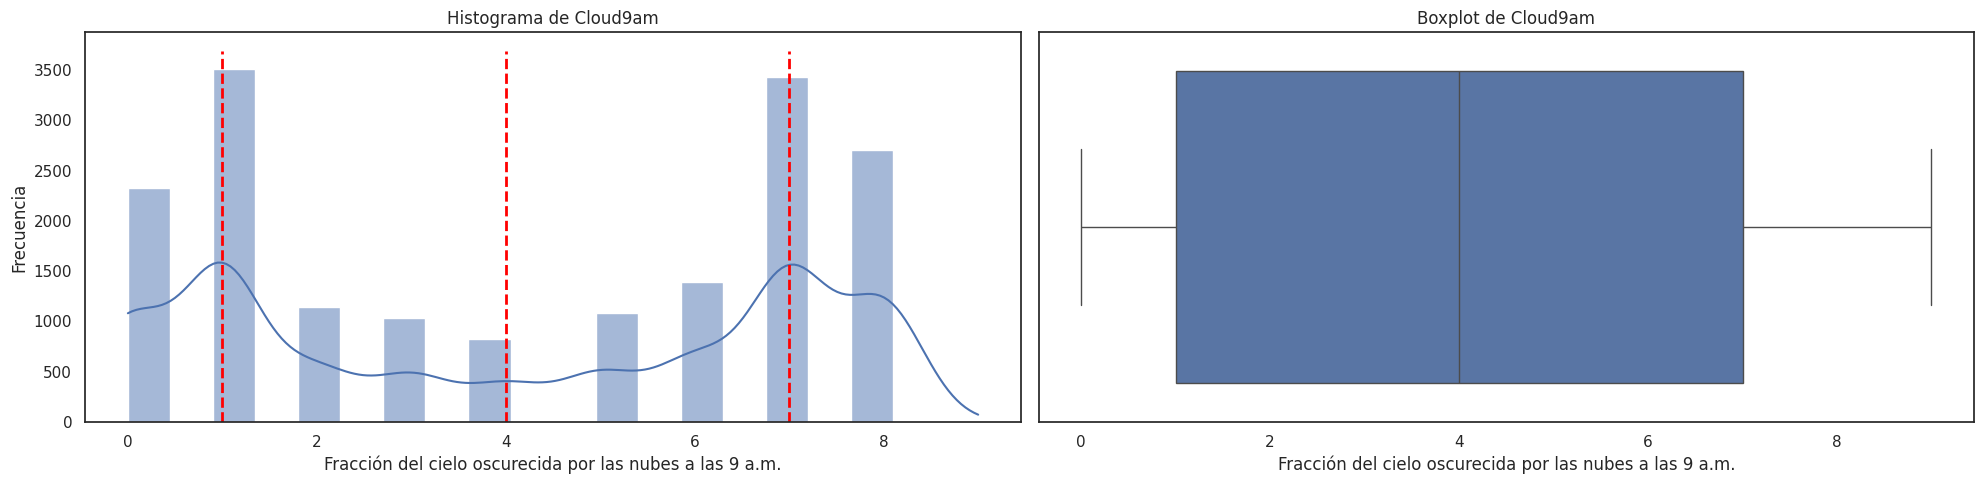

In [123]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))


# Histograma
sns.histplot(train['Cloud9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Cloud9am')
axs[0].set_xlabel('Fracción del cielo oscurecida por las nubes a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Cloud9am'].quantile(0.25)
q2 = train['Cloud9am'].quantile(0.5)
q3 = train['Cloud9am'].quantile(0.75)


# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Cloud9am'], ax=axs[1])
axs[1].set_title('Boxplot de Cloud9am')
axs[1].set_xlabel('Fracción del cielo oscurecida por las nubes a las 9 a.m.')

plt.tight_layout()
plt.show()



### Cloud3pm

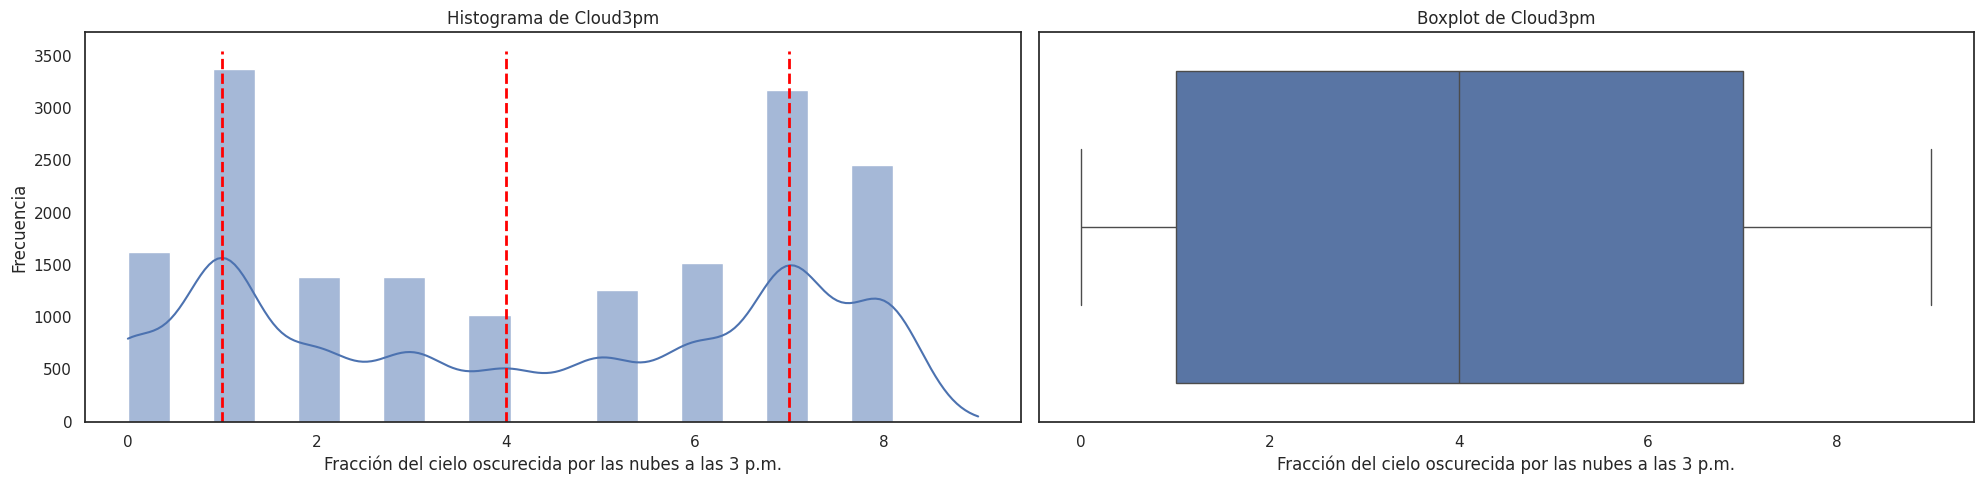

,Cloud3pm
count,17213.000000
mean,4.164759
std,2.833053
min,0.000000
25%,1.000000
50%,4.000000
75%,7.000000
max,9.000000


In [124]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Cloud3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Cloud3pm')
axs[0].set_xlabel('Fracción del cielo oscurecida por las nubes a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Cloud3pm'].quantile(0.25)
q2 = train['Cloud3pm'].quantile(0.5)
q3 = train['Cloud3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Cloud3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Cloud3pm')
axs[1].set_xlabel('Fracción del cielo oscurecida por las nubes a las 3 p.m.')

plt.tight_layout()
plt.show()

train['Cloud3pm'].describe()

### Temp9am

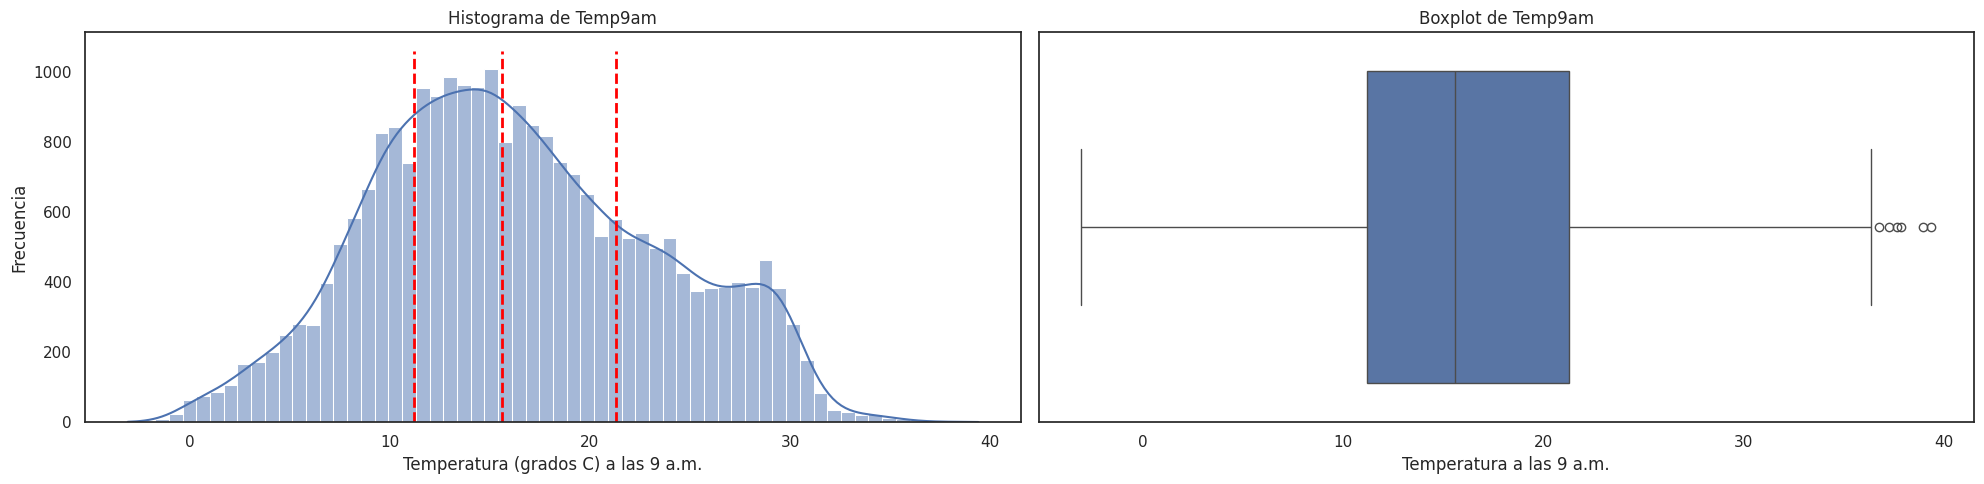

,Temp9am
count,24681.000000
mean,16.321373
std,7.091680
min,-3.100000
25%,11.200000
50%,15.600000
75%,21.300000
max,39.400000


In [125]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Temp9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Temp9am')
axs[0].set_xlabel('Temperatura (grados C) a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Temp9am'].quantile(0.25)
q2 = train['Temp9am'].quantile(0.5)
q3 = train['Temp9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Temp9am'], ax=axs[1])
axs[1].set_title('Boxplot de Temp9am')
axs[1].set_xlabel('Temperatura a las 9 a.m.')

plt.tight_layout()
plt.show()

train['Temp9am'].describe()

### Temp3pm

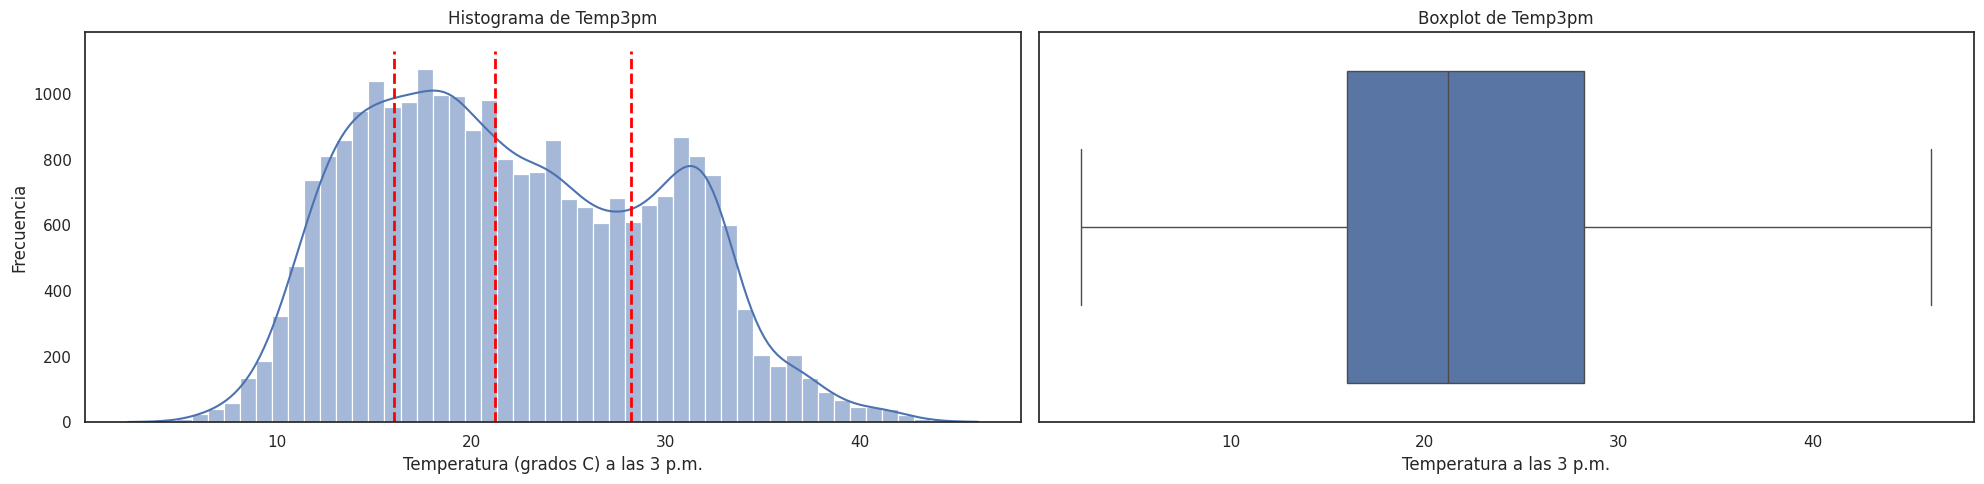

,Temp3pm
count,24728.000000
mean,22.068214
std,7.453837
min,2.300000
25%,16.000000
50%,21.200000
75%,28.200000
max,46.100000


In [126]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))


# Histograma
sns.histplot(train['Temp3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Temp3pm')
axs[0].set_xlabel('Temperatura (grados C) a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Temp3pm'].quantile(0.25)
q2 = train['Temp3pm'].quantile(0.5)
q3 = train['Temp3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Temp3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Temp3pm')
axs[1].set_xlabel('Temperatura a las 3 p.m.')

plt.tight_layout()
plt.show()

train['Temp3pm'].describe()

### RainToday

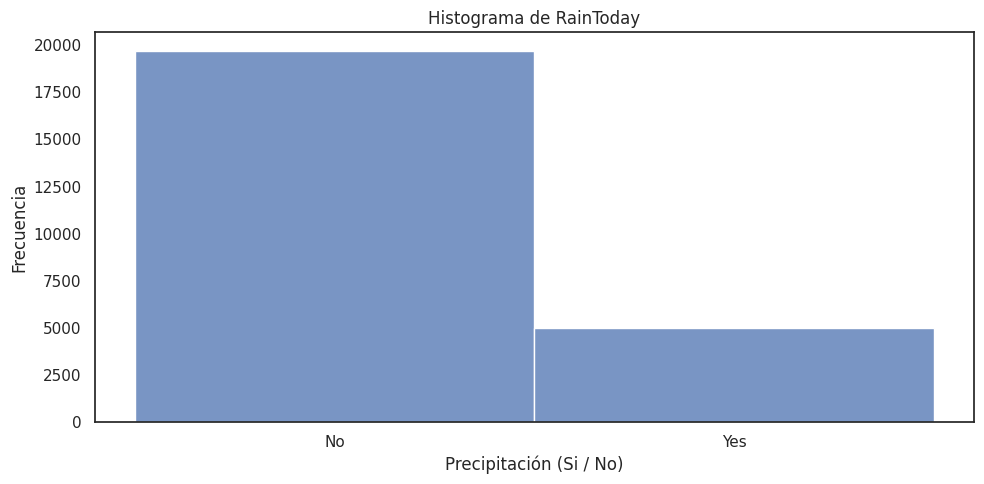

,RainToday
count,24681
unique,2
top,No
freq,19708


In [127]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(train['RainToday'])
axs.set_title('Histograma de RainToday')
axs.set_xlabel('Precipitación (Si / No)')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

train['RainToday'].describe()

### RainTomorrow

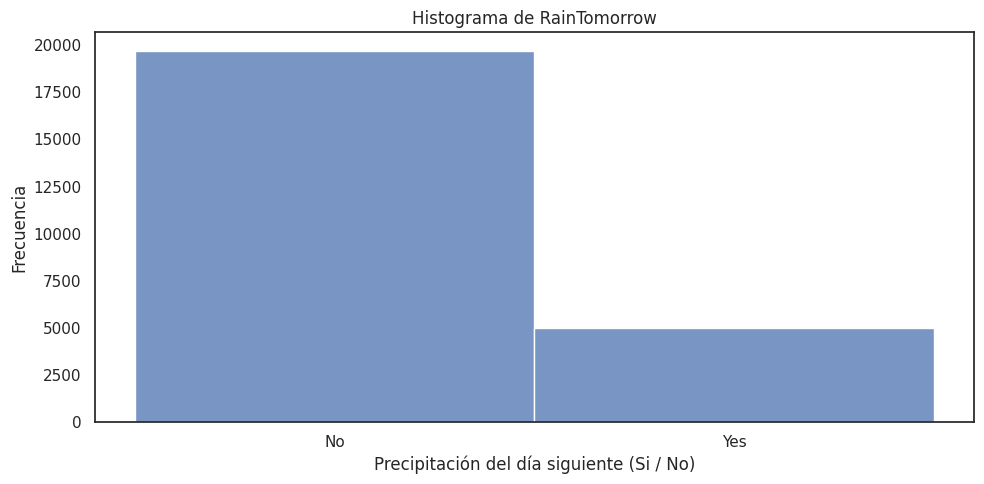

,RainTomorrow
count,24681
unique,2
top,No
freq,19709


In [128]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(train['RainTomorrow'])
axs.set_title('Histograma de RainTomorrow')
axs.set_xlabel('Precipitación del día siguiente (Si / No)')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

train['RainTomorrow'].describe()

### Analisis y observaciones luego de la vizualisacion de los datos

Las siguientes caracteristicas presentan valores atípicos: , **MinTemp**, **MaxTemp**, **Rainfall**, **Evaporation**, **WindGustSpeed**, **WindSpeed9am**, ****, **WindSpeed3pm**, **Humidity9am**, **Pressure9am**, **Pressure3pm**, **Temp9am** y **Temp3pm**.

Los valores atípicos pueden sesgar los parámetros del modelo al desviar la línea de regresión, afectando la relación general entre las variables. Podemos optar por tratarlos o no. Si decidimos tratarlos, debemos hacer una excepción con la columna RainTomorrow, que es la variable objetivo, y limitar la eliminación de outliers a un máximo del 10% del total de datos para evitar la pérdida de información valiosa y sesgar los resultados del modelo.

- Date: Fecha de observación.

        Debemos eliminarla porque no contiene información relevante.
        
- Location: El nombre de la ubicación de la estación meteorológica.

        Debemos descartar todas las ubicaciones que no nos interesen y luego las restantes asumirlas como una misma y única, para poder posteriormente eliminar Location y reducir la dimensionalidad para un modelo más simple.

- MinTemp: La temperatura mínima (°C).
- MaxTemp: La temperatura máxima (°C).

        Deberíamos tener en consideración la posibilidad de añadir a nuestro data set una nueva dimensión la cual sea la temperatura promedio durante el día (PromTemp = MaxTemp - MinTemp)

- Rainfall: La cantidad de lluvia registrada durante el día (mm).
- Evaporation: La evaporación del recipiente Clase A (mm) en el período de 24 horas a las 9 a.m.
- Sunshine: El número de horas de sol brillante en el día.
- WindGustDir: La dirección de la ráfaga de viento más fuerte en las 24 horas hasta la medianoche.
- WindGustSpeed: La velocidad (km/h) de la ráfaga de viento más fuerte en las 24 horas hasta la medianoche.
- WindDir9am: Dirección del viento a las 9 a.m.
- WindDir3pm: Dirección del viento a las 3 p.m.
- WindSpeed9am: Velocidad del viento (km/h) promediada de las 9 a.m.
- WindSpeed3pm: Velocidad del viento (km/h) promediada de las 3 p.m.
- Humidity9am: Humedad (porcentaje) a las 9 a.m.
- Humidity3pm: Humedad (porcentaje) a las 3 p.m.

        Deberíamos tener en consideración la posibilidad de añadir a nuestro data set una nueva dimensión la cual sea la diferencia de humedad (ΔHumidity = Humidity3pm - Humidity9am)

- Pressure9am: La presión atmosférica (hPa) a las 9 a. m.
- Pressure3pm: La presión atmosférica (hPa) a las 3 p. m.

        Deberíamos tener en consideración la posibilidad de añadir a nuestro data set una nueva dimensión la cual sea la diferencia de presión atmosférica (ΔPressure = Pressure3pm - Pressure9am)

- Cloud9am: Fracción del cielo oscurecida por las nubes a las 9 a.m. Esto se mide en "oktas", que son una unidad de octavos. Registra cuantos
- Cloud3pm: Fracción del cielo oscurecida por las nubes a las 3 p.m. Esto se mide en "oktas", que son una unidad de octavos. Registra cuantos
- Temp9am: Temperatura (grados C) a las 9 a.m.
- Temp3pm: Temperatura (grados C) a las 3 p.m.
- RainToday: Booleano: 1 si la precipitación (mm) en las 24 horas hasta las 9 a. m. excede 1 mm; de lo contrario, 0
- RainTomorrow: Booleano: 1 si la precipitación (mm) en las siguientes 24 horas hasta las 9 a. m. excede 1 mm; de lo contrario, 0

### Desbalance
El dataset está desbalanceado en la variable objetivo RainTomorrow. Hay una predominancia de la clase "No", lo que sugiere que la mayoría de los días no llovió. Esto es relevante porque entrenar un modelo en un dataset desbalanceado puede llevar a que el modelo se sesgue hacia la clase mayoritaria, afectando su capacidad de predecir correctamente la clase minoritaria ("Yes").

# Manejo de datos faltantes

**Datos numericos:** Usaremos la mediana para rellenar los datos faltantes en las variables numéricas. A diferencia de la media, la mediana no se ve influenciada por los valores atípicos, lo que hace que sea una opción más robusta en conjuntos de datos con muchos valores extremos.

**Datos categoricos:**  Usaremos la moda para rellenar los datos faltantes en las variables categóricas. La moda representa la categoría más frecuente, y estamos asumiendo que los valores faltantes probablemente pertenezcan a esta categoría. Aunque esto no siempre refleja la realidad, es una suposición razonable cuando no se dispone de información adicional.

### Completado de datos de Train

Rellenamos los datos faltantes con la moda para los categoricos y con la mediana para los numericos

In [129]:
# Manejo de datos faltantes
# Calcular la mediana y la moda en el conjunto de entrenamiento
numeric_cols = train.select_dtypes(include=np.number).columns
categorical_cols = train.select_dtypes(include='object').columns

# Imputación en el conjunto de entrenamiento
train[numeric_cols] = train[numeric_cols].fillna(train[numeric_cols].median())
train[categorical_cols] = train[categorical_cols].fillna(train[categorical_cols].mode().iloc[0])


In [130]:
train[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']].isnull().sum()

,0
WindGustDir,0
WindDir9am,0
WindDir3pm,0
RainToday,0
RainTomorrow,0


In [131]:
columns_to_check = [col for col in train.columns if col not in ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]
train[columns_to_check].isnull().sum()

,0
MinTemp,0
MaxTemp,0
Rainfall,0
Evaporation,0
Sunshine,0
WindGustSpeed,0
WindSpeed9am,0
WindSpeed3pm,0
Humidity9am,0
Humidity3pm,0


### Completado de datos de Test

Vemos que si hay datos faltantes, por lo tanto, rellenamos los datos faltantes con la moda para los categoricos y con la mediana para los numericos

In [132]:
# Manejo de datos faltantes
# Calcular la mediana y la moda en el conjunto de entrenamiento
numeric_cols = train.select_dtypes(include=np.number).columns
categorical_cols = train.select_dtypes(include='object').columns


# Usar las estadísticas calculadas en el conjunto de entrenamiento para imputar en el conjunto de prueba
test[numeric_cols] = test[numeric_cols].fillna(train[numeric_cols].median())
test[categorical_cols] = test[categorical_cols].fillna(train[categorical_cols].mode().iloc[0])

In [133]:
test.isnull().sum()

,0
MinTemp,0
MaxTemp,0
Rainfall,0
Evaporation,0
Sunshine,0
WindGustDir,0
WindGustSpeed,0
WindDir9am,0
WindDir3pm,0
WindSpeed9am,0


# One hot enconding (Dummies)

Simplifiqué las 16 categorías de direcciones de viento de mi DataFrame agrupándolas en 4 principales: 'N', 'S', 'E' y 'W'. Usé un diccionario para mapear las direcciones originales a las nuevas, y apliqué este mapeo a la columna usando `map` de pandas, reduciendo así las categorías de 16 a 4 para facilitar el análisis.

## Dummies de Train

In [134]:
diccionario = {
    'N': ['N', 'NNW', 'NNE', 'NE', 'NW'],
    'S': ['S', 'SSW', 'SSE', 'SE', 'SW'],
    'E': ['E', 'ENE', 'ESE'],
    'W': ['W', 'WNW', 'WSW'],
}

# Invertir el diccionario para el mapeo
diccionario_invertido = {valor: clave for clave, lista_valores in diccionario.items() for valor in lista_valores}

# Aplicar la transformación a WindGustDir
train['WindGustDir'] = train['WindGustDir'].map(diccionario_invertido)

# Aplicar la transformación a WindDir9am
train['WindDir9am'] = train['WindDir9am'].map(diccionario_invertido)

# Aplicar la transformación a WindDir3pm
train['WindDir3pm'] = train['WindDir3pm'].map(diccionario_invertido)

In [135]:
train[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]

,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
0,W,W,W,No,No
1,W,N,W,No,No
2,W,W,W,No,No
3,N,S,E,No,No
4,W,E,N,No,No
...,...,...,...,...,...
141680,N,E,N,No,No
141681,N,N,N,No,No
141682,N,N,N,No,No
141683,N,N,N,No,No


Usando la función de pandas get_dummies  aplicará One Hot Encoding a las columnas del Dataframe columnas_categoricas. El resultado será un nuevo DataFrame donde cada valor categórico único en cada columna se convierte en una nueva columna y se codifica como 1 o 0.

In [136]:
columns_to_dummy = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
train_dummies = pd.get_dummies(train, columns=columns_to_dummy, drop_first=True)

In [137]:
train_dummies

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes,RainTomorrow_Yes
0,13.4,22.9,0.6,5.0,9.1,44.0,20.0,24.0,71.0,22.0,...,False,True,False,False,True,False,False,True,False,False
1,7.4,25.1,0.0,5.0,9.1,44.0,4.0,22.0,44.0,25.0,...,False,True,True,False,False,False,False,True,False,False
2,12.9,25.7,0.0,5.0,9.1,46.0,19.0,26.0,38.0,30.0,...,False,True,False,False,True,False,False,True,False,False
3,9.2,28.0,0.0,5.0,9.1,24.0,11.0,9.0,45.0,16.0,...,False,False,False,True,False,False,False,False,False,False
4,17.5,32.3,1.0,5.0,9.1,41.0,7.0,20.0,82.0,33.0,...,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141680,23.3,32.8,0.0,8.4,10.5,35.0,13.0,24.0,62.0,53.0,...,False,False,False,False,False,True,False,False,False,False
141681,24.3,32.3,0.0,8.0,9.1,35.0,11.0,24.0,65.0,47.0,...,False,False,True,False,False,True,False,False,False,False
141682,23.8,32.9,0.0,5.6,10.9,33.0,2.0,24.0,62.0,45.0,...,False,False,True,False,False,True,False,False,False,False
141683,23.3,33.2,0.0,7.6,10.7,33.0,4.0,20.0,60.0,41.0,...,False,False,True,False,False,True,False,False,False,False


Al tener múltiples categorías en cada una de las columna categóricas, eliminamos una de las variables dummy para evitar la colinealidad. Por ejemplo la columna RainToday_No, es una columna redundante porque es perfectamente inversas a RainToday_Yes, es decir, si un día tiene un '1' en RainToday_No, entonces tiene un '0' en RainToday_Yes, y viceversa.

In [138]:
train_dummies.replace({True: 1, False: 0}, inplace=True)

<ipython-input-138-17a59044c2d9>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_dummies.replace({True: 1, False: 0}, inplace=True)


## Dummies de Test

In [139]:
diccionario = {
    'N': ['N', 'NNW', 'NNE', 'NE', 'NW'],
    'S': ['S', 'SSW', 'SSE', 'SE', 'SW'],
    'E': ['E', 'ENE', 'ESE'],
    'W': ['W', 'WNW', 'WSW'],
}

# Invertir el diccionario para el mapeo
diccionario_invertido = {valor: clave for clave, lista_valores in diccionario.items() for valor in lista_valores}

# Aplicar la transformación a WindGustDir
test['WindGustDir'] = test['WindGustDir'].map(diccionario_invertido)

# Aplicar la transformación a WindDir9am
test['WindDir9am'] = test['WindDir9am'].map(diccionario_invertido)

# Aplicar la transformación a WindDir3pm
test['WindDir3pm'] = test['WindDir3pm'].map(diccionario_invertido)

In [140]:
test[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]

,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
2421,S,S,S,No,No
2422,W,S,W,No,No
2423,N,S,S,No,No
2424,S,S,S,No,No
2425,N,E,N,No,Yes
...,...,...,...,...,...
142299,E,S,S,No,No
142300,E,E,W,No,No
142301,E,S,N,No,No
142302,E,E,N,No,No


Usando la función de pandas get_dummies  aplicará One Hot Encoding a las columnas del Dataframe columnas_categoricas. El resultado será un nuevo DataFrame donde cada valor categórico único en cada columna se convierte en una nueva columna y se codifica como 1 o 0.

In [141]:
columns_to_dummy = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
test_dummies = pd.get_dummies(test, columns=columns_to_dummy)

Al tener múltiples categorías en cada una de las columna categóricas, eliminamos una de las variables dummy para evitar la colinealidad. Por ejemplo la columna RainToday_No, es una columna redundante porque es perfectamente inversas a RainToday_Yes, es decir, si un día tiene un '1' en RainToday_No, entonces tiene un '0' en RainToday_Yes, y viceversa.

In [142]:
test_dummies = pd.get_dummies(test, columns=columns_to_dummy, drop_first=True)

In [143]:
test_dummies.replace({True: 1, False: 0}, inplace=True)

<ipython-input-143-4a69d8ccb6ee>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_dummies.replace({True: 1, False: 0}, inplace=True)


In [144]:
test_dummies

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes,RainTomorrow_Yes
2421,13.1,29.6,0.0,5.0,9.1,22.0,2.0,15.0,79.0,52.0,...,1,0,0,1,0,0,1,0,0,0
2422,16.0,29.0,0.0,5.0,9.1,33.0,6.0,20.0,82.0,46.0,...,0,1,0,1,0,0,0,1,0,0
2423,8.6,27.5,0.0,5.0,9.1,22.0,6.0,11.0,64.0,40.0,...,0,0,0,1,0,0,1,0,0,0
2424,8.3,29.2,0.0,5.0,9.1,22.0,4.0,13.0,63.0,44.0,...,1,0,0,1,0,0,1,0,0,0
2425,11.3,31.8,0.0,5.0,9.1,54.0,2.0,7.0,64.0,31.0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142299,21.2,32.6,0.0,7.6,8.6,37.0,13.0,11.0,56.0,28.0,...,0,0,0,1,0,0,1,0,0,0
142300,20.7,32.8,0.0,5.6,11.0,33.0,17.0,11.0,46.0,23.0,...,0,0,0,0,0,0,0,1,0,0
142301,19.5,31.8,0.0,6.2,10.6,26.0,9.0,17.0,62.0,58.0,...,0,0,0,1,0,1,0,0,0,0
142302,20.2,31.7,0.0,5.6,10.7,30.0,15.0,7.0,73.0,32.0,...,0,0,0,0,0,1,0,0,0,0


# Matriz de correlación

## Matriz de correlación numérica

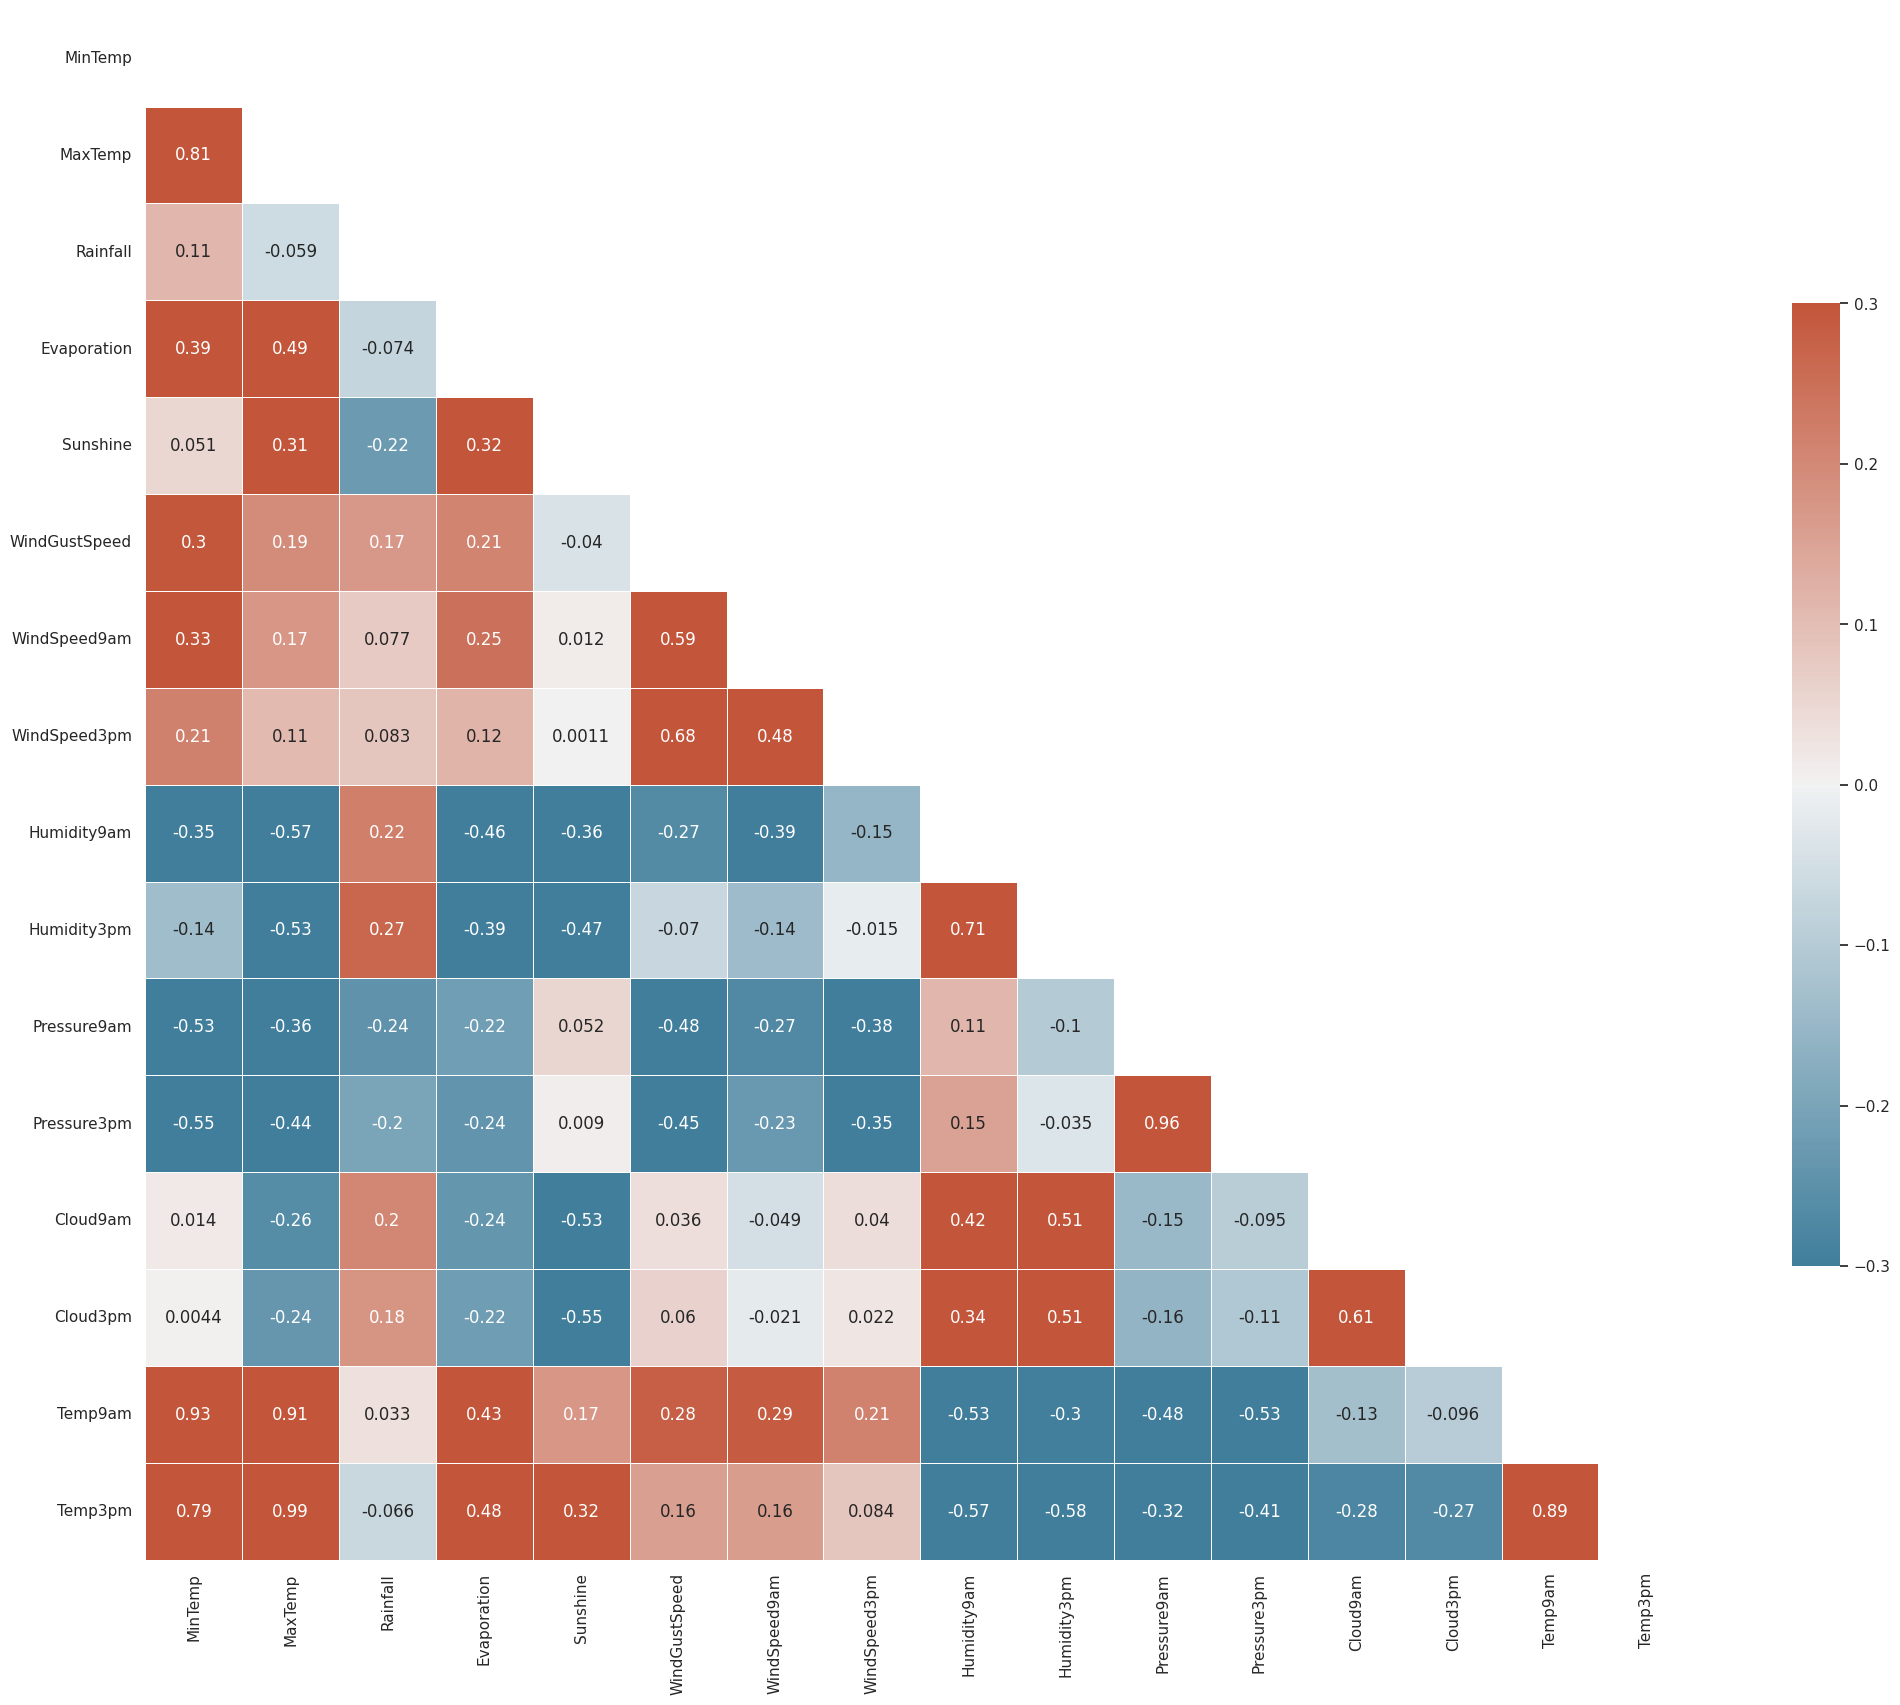

In [145]:
sns.set_theme(style="white")
# Creación de la matriz de correlación
corr = train_dummies[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm']].corr()

# Generar una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configurar la figura de matplotlib
f, ax = plt.subplots(figsize=(25, 25))

# Generar un colormap diverging personalizado
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dibujar el heatmap con la máscara y el aspecto correcto
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.3 ,vmax=.3,center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


## Matriz de correlación categórica

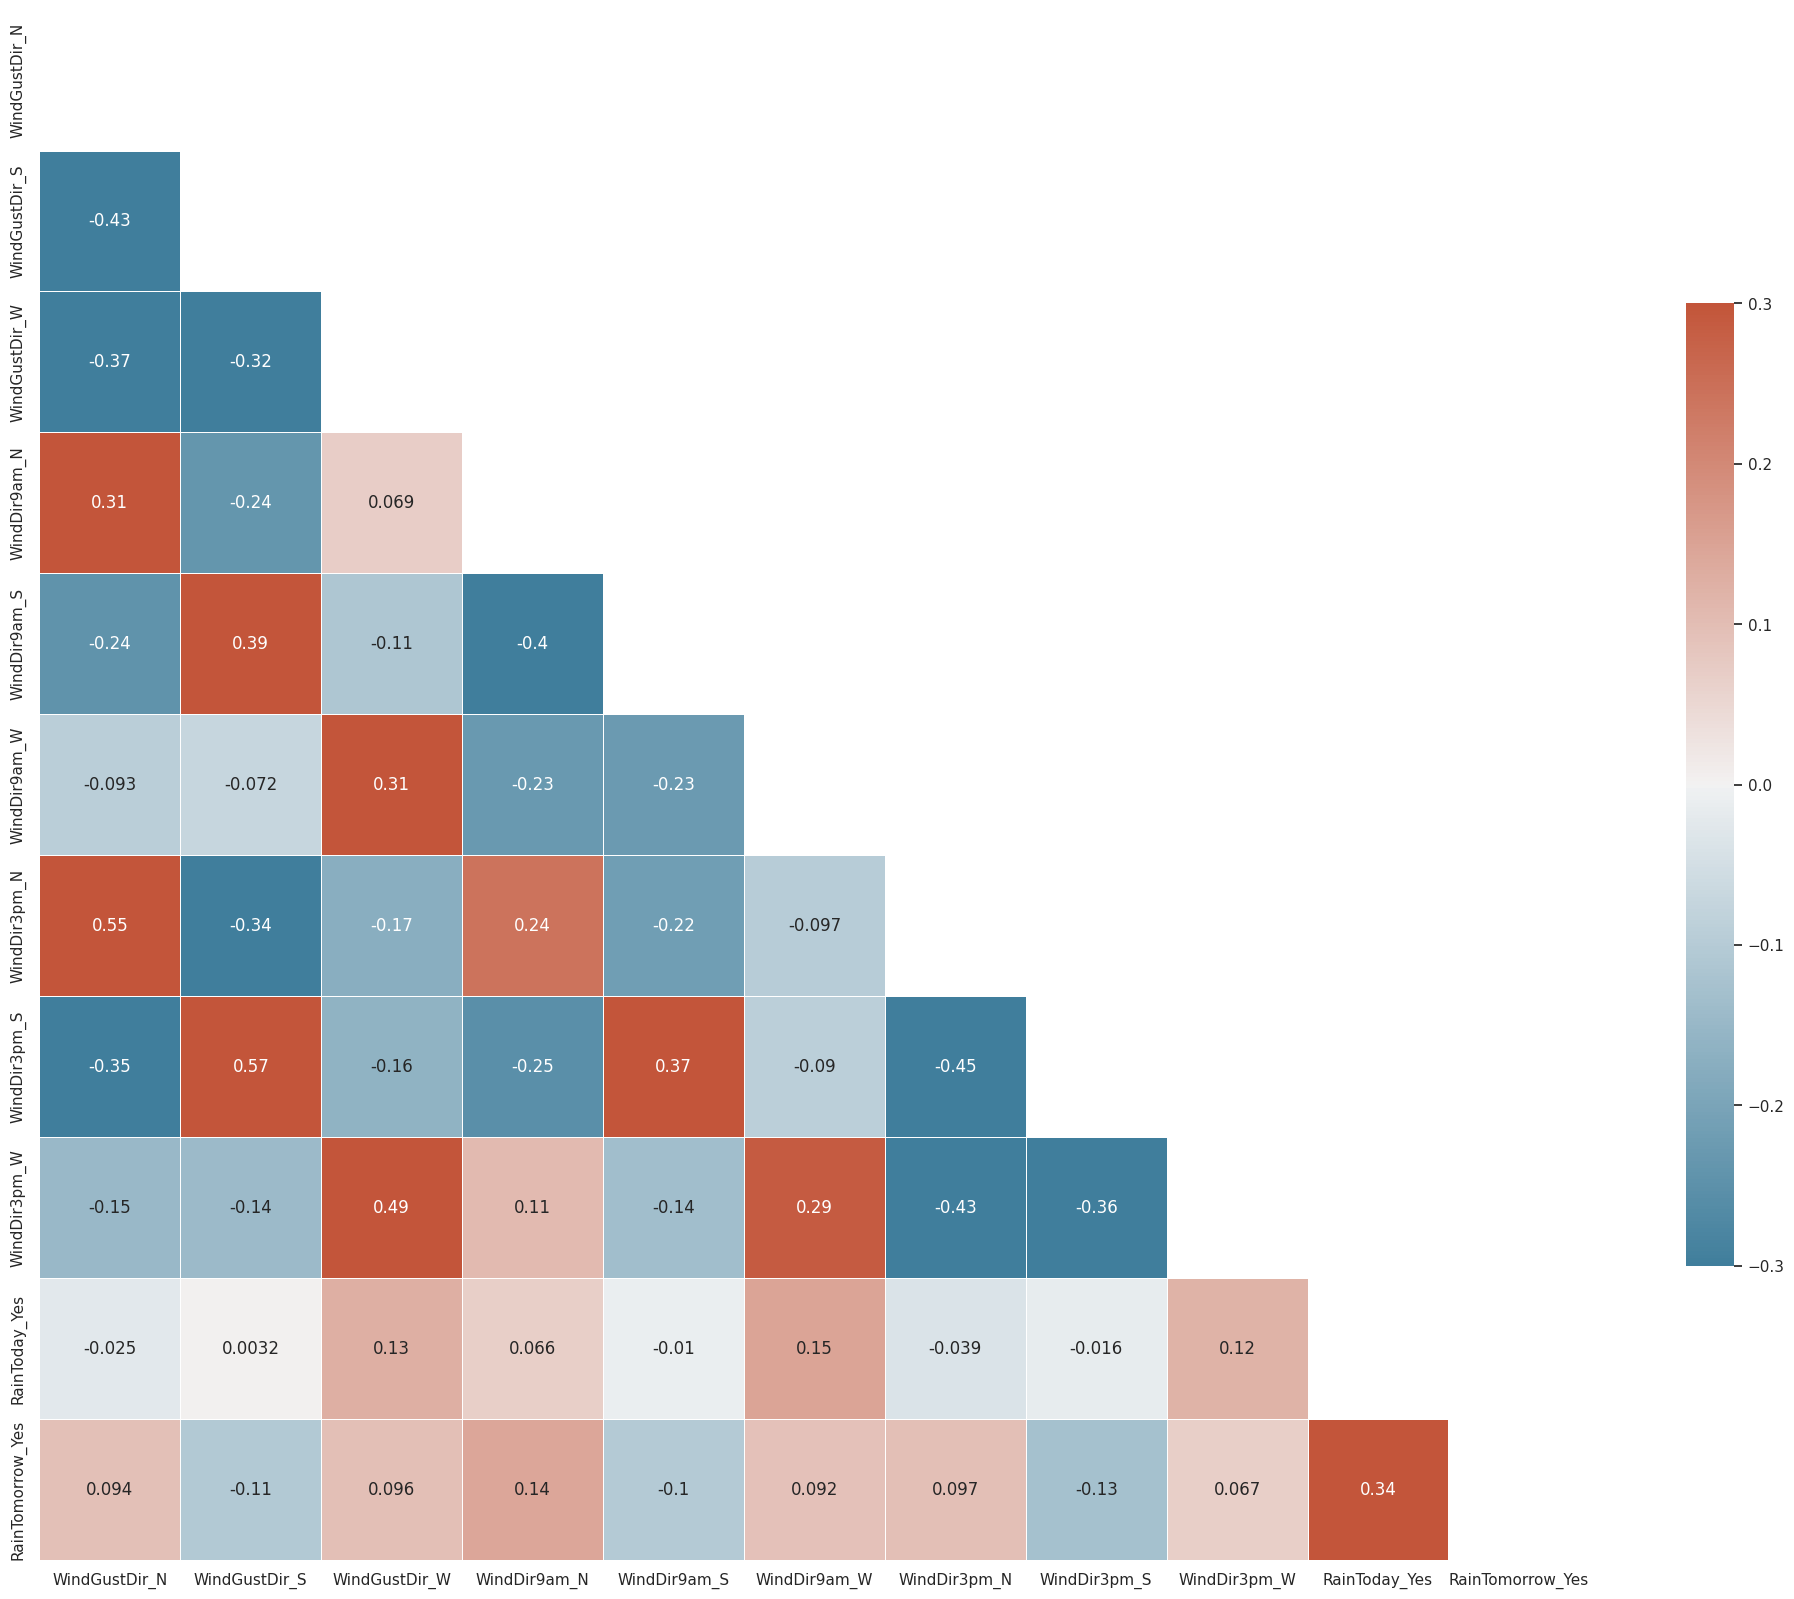

In [146]:
sns.set_theme(style="white")

# Calcular la matriz de correlación
corr = train_dummies[['WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes', 'RainTomorrow_Yes']].corr()

# Generar una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configurar la figura de matplotlib
f, ax = plt.subplots(figsize=(25, 25))

# Generar un colormap diverging personalizado
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dibujar el heatmap con la máscara y el aspecto correcto
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.3 ,vmax=.3, center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


La razón por la cual realizamos la matriz de correlación solo en el conjunto de entrenamiento (train) y no en el de prueba (test) es para evitar lo que se conoce como data leakage.

- **Data leakage** ocurre cuando utilizas información del conjunto de prueba (test) para tomar decisiones durante el entrenamiento del modelo.

# Estandarización

Estandarizamos las características porque pueden tener diferentes rangos de valores.
Estandarizarlas asegura que todas las características tengan la misma escala, lo que evita que las características
con mayores rangos dominen el modelo.

In [147]:
# Crear el estandarizador
scaler = StandardScaler()

## Estandarización de Train

In [148]:
# Seleccionar las columnas a estandarizar
columns_to_standardize = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
# Aplicar la estandarización a las columnas seleccionadas
train_dummies[columns_to_standardize] = scaler.fit_transform(train_dummies[columns_to_standardize])

In [149]:
train_dummies

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes,RainTomorrow_Yes
0,0.282264,-0.074650,-0.194020,-0.156907,0.185719,0.422702,0.849348,0.802196,0.161471,-1.207141,...,0,1,0,0,1,0,0,1,0,0
1,-0.556150,0.214134,-0.273607,-0.156907,0.185719,0.422702,-1.052267,0.548922,-1.212748,-1.060877,...,0,1,1,0,0,0,0,1,0,0
2,0.212396,0.292893,-0.273607,-0.156907,0.185719,0.578475,0.730497,1.055471,-1.518130,-0.817104,...,0,1,0,0,1,0,0,1,0,0
3,-0.304626,0.594804,-0.273607,-0.156907,0.185719,-1.135026,-0.220311,-1.097359,-1.161851,-1.499669,...,0,0,0,1,0,0,0,0,0,0
4,0.855180,1.159245,-0.140962,-0.156907,0.185719,0.189043,-0.695715,0.295648,0.721338,-0.670840,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141680,1.665646,1.224877,-0.273607,0.709313,0.704257,-0.278276,0.017391,0.802196,-0.296602,0.304253,...,0,0,0,0,0,1,0,0,0,0
141681,1.805382,1.159245,-0.273607,0.607405,0.185719,-0.278276,-0.220311,0.802196,-0.143911,0.011725,...,0,0,1,0,0,1,0,0,0,0
141682,1.735514,1.238004,-0.273607,-0.004045,0.852411,-0.434049,-1.289969,0.802196,-0.296602,-0.085784,...,0,0,1,0,0,1,0,0,0,0
141683,1.665646,1.277384,-0.273607,0.505497,0.778334,-0.434049,-1.052267,0.295648,-0.398396,-0.280803,...,0,0,1,0,0,1,0,0,0,0


## Estandarización de Test

In [150]:
# Seleccionar las columnas a estandarizar
columns_to_standardize = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

# Aplicar la estandarización a las columnas seleccionadas
test_dummies[columns_to_standardize] = scaler.transform(test_dummies[columns_to_standardize])

In [151]:
test_dummies

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes,RainTomorrow_Yes
2421,0.240343,0.804828,-0.273607,-0.156907,0.185719,-1.290799,-1.289969,-0.337537,0.568647,0.255498,...,1,0,0,1,0,0,1,0,0,0
2422,0.645577,0.726069,-0.273607,-0.156907,0.185719,-0.434049,-0.814565,0.295648,0.721338,-0.037030,...,0,1,0,1,0,0,0,1,0,0
2423,-0.388467,0.529171,-0.273607,-0.156907,0.185719,-1.290799,-0.814565,-0.844085,-0.194808,-0.329558,...,0,0,0,1,0,0,1,0,0,0
2424,-0.430388,0.752322,-0.273607,-0.156907,0.185719,-1.290799,-1.052267,-0.590811,-0.245705,-0.134539,...,1,0,0,1,0,0,1,0,0,0
2425,-0.011181,1.093612,-0.273607,-0.156907,0.185719,1.201566,-1.289969,-1.350633,-0.194808,-0.768349,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142299,1.372202,1.198624,-0.273607,0.505497,0.000527,-0.122503,0.017391,-0.844085,-0.601984,-0.914613,...,0,0,0,1,0,0,1,0,0,0
142300,1.302334,1.224877,-0.273607,-0.004045,0.889449,-0.434049,0.492795,-0.844085,-1.110954,-1.158386,...,0,0,0,0,0,0,0,1,0,0
142301,1.134651,1.093612,-0.273607,0.148818,0.741295,-0.979253,-0.458013,-0.084263,-0.296602,0.548026,...,0,0,0,1,0,1,0,0,0,0
142302,1.232466,1.080485,-0.273607,-0.004045,0.778334,-0.667708,0.255093,-1.350633,0.263265,-0.719595,...,0,0,0,0,0,1,0,0,0,0


**En el conjunto de entrenamiento:**
Se aplica fit_transform del StandardScaler para ajustar el escalador a los datos de entrenamiento y transformar esos datos.

**En el conjunto de prueba:**
Se aplica transform del StandardScaler ya ajustado para transformar los datos de prueba usando la misma media y desviación estándar que en el conjunto de entrenamiento.

Esto asegura una transformación consistente y evita la fuga de información.



# División del conjunto de datos de entrenamiento


In [152]:
# lo hacemmos con dummies o con train y tets normal?
y_train = train_dummies['RainTomorrow_Yes']
x_train = train_dummies.drop(['RainTomorrow_Yes'], axis=1)

y_test = test_dummies['RainTomorrow_Yes']
x_test = test_dummies.drop(['RainTomorrow_Yes'], axis=1)


In [153]:
x_train

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindGustDir_N,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes
0,0.282264,-0.074650,-0.194020,-0.156907,0.185719,0.422702,0.849348,0.802196,0.161471,-1.207141,...,0,0,1,0,0,1,0,0,1,0
1,-0.556150,0.214134,-0.273607,-0.156907,0.185719,0.422702,-1.052267,0.548922,-1.212748,-1.060877,...,0,0,1,1,0,0,0,0,1,0
2,0.212396,0.292893,-0.273607,-0.156907,0.185719,0.578475,0.730497,1.055471,-1.518130,-0.817104,...,0,0,1,0,0,1,0,0,1,0
3,-0.304626,0.594804,-0.273607,-0.156907,0.185719,-1.135026,-0.220311,-1.097359,-1.161851,-1.499669,...,1,0,0,0,1,0,0,0,0,0
4,0.855180,1.159245,-0.140962,-0.156907,0.185719,0.189043,-0.695715,0.295648,0.721338,-0.670840,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141680,1.665646,1.224877,-0.273607,0.709313,0.704257,-0.278276,0.017391,0.802196,-0.296602,0.304253,...,1,0,0,0,0,0,1,0,0,0
141681,1.805382,1.159245,-0.273607,0.607405,0.185719,-0.278276,-0.220311,0.802196,-0.143911,0.011725,...,1,0,0,1,0,0,1,0,0,0
141682,1.735514,1.238004,-0.273607,-0.004045,0.852411,-0.434049,-1.289969,0.802196,-0.296602,-0.085784,...,1,0,0,1,0,0,1,0,0,0
141683,1.665646,1.277384,-0.273607,0.505497,0.778334,-0.434049,-1.052267,0.295648,-0.398396,-0.280803,...,1,0,0,1,0,0,1,0,0,0


In [154]:
y_train

,RainTomorrow_Yes
0,0
1,0
2,0
3,0
4,0
...,...
141680,0
141681,0
141682,0
141683,0


# Regresión Logística (Clasificación).


In [167]:
# Inicializar y entrenar un modelo de regresión logística
model = LogisticRegression()
start = time.time()
model.fit(x_train, np.ravel(y_train))
end = time.time()

no_opt_time = end - start

# Realizar predicciones en el conjunto de prueba
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
model

LogisticRegression()

In [168]:
# Calcular métricas
accuracy_logreg = accuracy_score(y_train, y_pred_train) # compara el valor real y el predicho

confusion_matrix_logreg = confusion_matrix(y_train, y_pred_train)

classification_report_logreg = classification_report(y_train, y_pred_train)

# Imprimir métricas
print("Métricas para logreg train:")
print(f'Precisión: {accuracy_logreg}')
print("Matriz de confusión:")
print(confusion_matrix_logreg)
print("Reporte de clasificación:")
print(classification_report_logreg)

Métricas para logreg train:
Precisión: 0.8729172550127082
Matriz de confusión:
[[18895   920]
 [ 2230  2742]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     19815
           1       0.75      0.55      0.64      4972

    accuracy                           0.87     24787
   macro avg       0.82      0.75      0.78     24787
weighted avg       0.87      0.87      0.87     24787



In [169]:
# Calcular métricas
accuracy_logreg = accuracy_score(y_test, y_pred_test)

confusion_matrix_logreg = confusion_matrix(y_test, y_pred_test)

classification_report_logreg = classification_report(y_test, y_pred_test)

# Imprimir métricas
print("Métricas para logreg test:")
print(f'Precisión: {accuracy_logreg}')
print("Matriz de confusión:")
print(confusion_matrix_logreg)
print("Reporte de clasificación:")
print(classification_report_logreg)

Métricas para logreg test:
Precisión: 0.858481421647819
Matriz de confusión:
[[4676  225]
 [ 651  638]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4901
           1       0.74      0.49      0.59      1289

    accuracy                           0.86      6190
   macro avg       0.81      0.72      0.75      6190
weighted avg       0.85      0.86      0.85      6190



El modelo de regresión logística presenta un desempeño sólido en el conjunto de entrenamiento, con una precisión del 87.29%. La matriz de confusión indica que el modelo tiene una F1-Score de 0.64 para la clase '1' (días con lluvia), reflejando desafíos en la identificación de estos eventos. En el conjunto de prueba, la precisión disminuye ligeramente al 85.85%, con un F1-Score para la clase '1' que baja a 0.59. Esto sugiere que, aunque el modelo es generalmente efectivo, tiene dificultades para predecir correctamente los días con lluvia en datos no vistos.

- La predicción es más precisa para los días sin lluvia, donde se observa un F1-Score de 0.91 en prueba, en comparación con el 0.59 para los días con lluvia.

**El F1-Score es una métrica crucial que combina precisión y recall, ofreciendo una evaluación más completa del rendimiento del modelo, especialmente en conjuntos de datos desbalanceados como el presente. La diferencia notable entre las métricas de ambas clases indica que se podrían considerar técnicas de re-balanceo o ajuste adicional para mejorar la detección de días con lluvia.**
### Análisis de Falsos Positivos y Falsos Negativos

- **Falsos Positivos (FP)**: En el conjunto de prueba, se identificaron 225 días como días con lluvia cuando en realidad no lo eran (verdaderos negativos). Esto significa que el modelo puede estar generando "falsas alarmas", clasificando incorrectamente días secos como días lluviosos. Este tipo de error puede llevar a decisiones inapropiadas, como la activación innecesaria de alertas meteorológicas.

- **Falsos Negativos (FN)**: Por otro lado, el modelo clasificó 651 días con lluvia como días sin lluvia. Este es un error crítico, ya que podría resultar en la falta de preparación para eventos de lluvia, afectando actividades que dependen del clima, como eventos al aire libre o el tráfico.


# Matriz de confusion

In [180]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


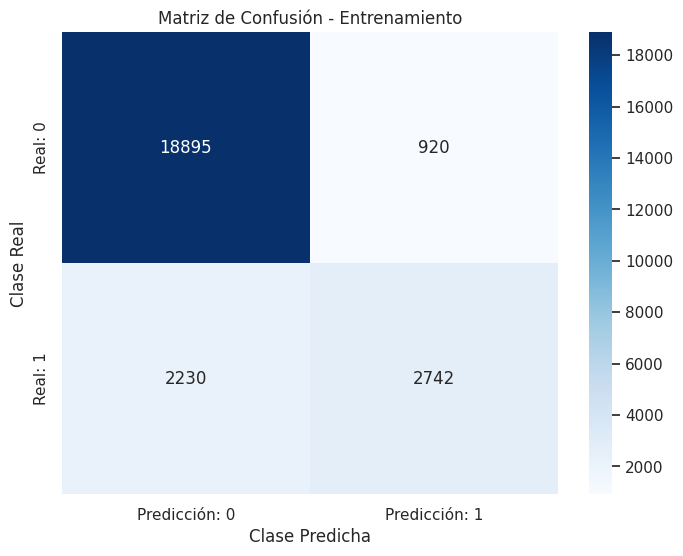

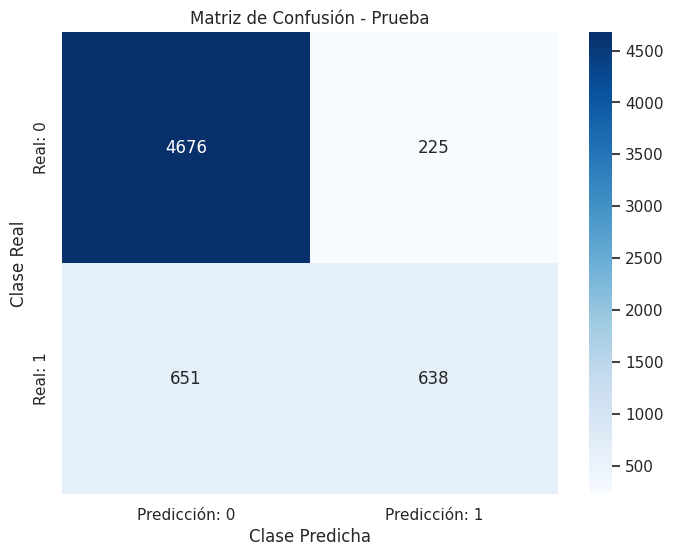

In [181]:

# Calcular matrices de confusión
confusion_matrix_logreg_train = confusion_matrix(y_train, y_pred_train)
confusion_matrix_logreg_test = confusion_matrix(y_test, y_pred_test)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, title='Matriz de Confusión', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=['Predicción: 0', 'Predicción: 1'],
                yticklabels=['Real: 0', 'Real: 1'])
    plt.title(title)
    plt.ylabel('Clase Real')
    plt.xlabel('Clase Predicha')
    plt.show()

# Graficar matriz de confusión para el conjunto de entrenamiento
plot_confusion_matrix(confusion_matrix_logreg_train, title='Matriz de Confusión - Entrenamiento')

# Graficar matriz de confusión para el conjunto de prueba
plot_confusion_matrix(confusion_matrix_logreg_test, title='Matriz de Confusión - Prueba')


# Curva Roc

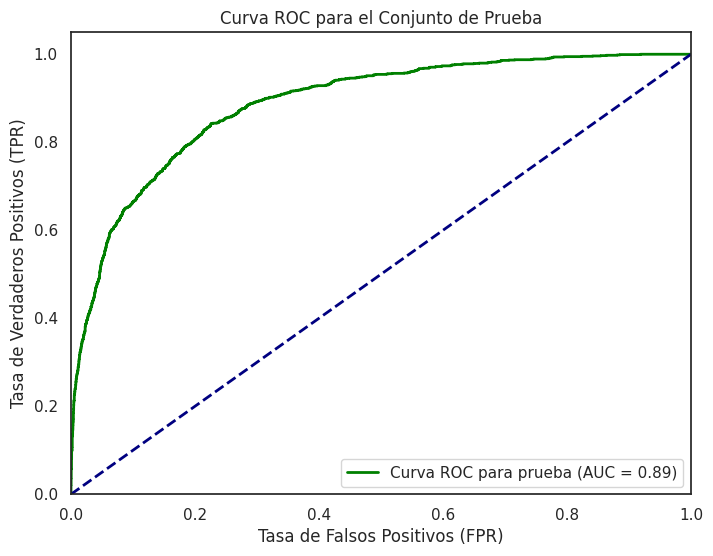

El área bajo la curva para prueba es de: 0.8866631451696262


In [170]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Reemplaza 'No' con 0 y 'Yes' con 1
y_test_binary = y_test.replace({'No': 0, 'Yes': 1})

# Obtengo las probabilidades de predicción del modelo para los datos de prueba
y_probs_test = model.predict_proba(x_test)[:, 1]

# Calculo la ROC y el AUC para los datos de prueba
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_probs_test, pos_label=1)
roc_auc_test = auc(fpr_test, tpr_test)

# Grafico la curva ROC para los datos de prueba
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='Curva ROC para prueba (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para el Conjunto de Prueba')
plt.legend(loc="lower right")
plt.show()

print(f"El área bajo la curva para prueba es de: {roc_auc_test}")



In [159]:
# Calcula la distancia euclidiana entre cada punto de la curva ROC y (0,1) para los datos de prueba
distances_test = np.sqrt((1 - tpr_test)**2 + fpr_test**2)

# Encuentra el índice del punto que minimiza la distancia para los datos de prueba
min_index_test = np.argmin(distances_test)

# Obtiene el umbral óptimo para los datos de prueba
optimal_threshold_test = thresholds_test[min_index_test]

print("Umbral óptimo para prueba:", optimal_threshold_test)

Umbral óptimo para prueba: 0.15458370345363337


### Curva ROC, Umbral y Área Bajo la Curva

AUC: 0.89

Umbral óptimo: 0.1545

- La curva ROC muestra que el modelo tiene un desempeño excelente tanto en el conjunto de entrenamiento como en el de prueba, con AUC cercanas a 1. Esto indica que el modelo es muy eficaz para diferenciar entre las clases.
- Los umbrales óptimos sugieren los puntos donde el modelo equilibra mejor la tasa de verdaderos positivos y la tasa de falsos positivos.

In [171]:
# Guardar el scaler para usarlo en la predicción
import joblib
joblib.dump(model, 'ModelRL.joblib')

['ModelRL.joblib']

## Clasificación

In [161]:
# Entrena el modelo base
logreg_base = LogisticRegression()
logreg_base.fit(x_train, y_train)

LogisticRegression()

In [164]:

# Realiza predicciones
y_pred_train_base = logreg_base.predict(x_train)
y_pred_test_base = logreg_base.predict(x_test)

# Calcula métricas para el conjunto de entrenamiento
print("Métricas de entrenamiento para el modelo base de clasificación:")
print("Precisión:", logreg_base.score(x_train, y_train))
print("Matriz de confusión:\n", confusion_matrix(y_train, y_pred_train_base))
print("Reporte de clasificación:\n", classification_report(y_train, y_pred_train_base))

# Calcula métricas para el conjunto de prueba
print("Métricas de prueba para el modelo base de clasificación:")
print("Precisión:", logreg_base.score(x_test, y_test))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_test_base))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred_test_base))


Métricas de entrenamiento para el modelo base de clasificación:
Precisión: 0.8729172550127082
Matriz de confusión:
 [[18895   920]
 [ 2230  2742]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92     19815
           1       0.75      0.55      0.64      4972

    accuracy                           0.87     24787
   macro avg       0.82      0.75      0.78     24787
weighted avg       0.87      0.87      0.87     24787

Métricas de prueba para el modelo base de clasificación:
Precisión: 0.858481421647819
Matriz de confusión:
 [[4676  225]
 [ 651  638]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.88      0.95      0.91      4901
           1       0.74      0.49      0.59      1289

    accuracy                           0.86      6190
   macro avg       0.81      0.72      0.75      6190
weighted avg       0.85      0.86      0.85      6190



El modelo de clasificación base demuestra un rendimiento robusto en el conjunto de entrenamiento, alcanzando una precisión del 87.29% y un F1-Score de 0.64 para la clase positiva (días con lluvia). En el conjunto de prueba, la precisión se reduce ligeramente al 85.85%, mientras que el F1-Score para la clase positiva desciende a 0.59. Este descenso en el F1-Score indica que el modelo enfrenta dificultades para identificar correctamente las instancias de lluvia en datos no vistos.

Aunque el modelo muestra un buen desempeño al predecir días sin lluvia, con un F1-Score de 0.91 en el conjunto de prueba, la identificación de días con lluvia presenta desafíos significativos, evidenciando un recall de solo 0.49 para la clase positiva.


**Estas métricas sugieren que, si bien el modelo es efectivo en general, se requieren mejoras para optimizar la detección de eventos de lluvia, especialmente en contextos donde la identificación precisa de estas instancias es crucial. Se podrían considerar técnicas de balanceo de clases o ajustes en el modelo para abordar esta limitación.**


In [165]:
# Guardar el scaler para usarlo en la predicción
import joblib
joblib.dump(logreg_base, 'Model_base_rl.joblib')

['Model_base_rl.joblib']

# conclusiones

En general, aunque el modelo muestra un buen ajuste en términos de precisión y F1-Score para la clase negativa (días sin lluvia), el rendimiento para la clase positiva (días con lluvia) indica que no han conseguido un buen fitting en este aspecto. Se podria mejorar esto con un balanceo de datos.